In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision
import torchvision.transforms

import numpy as np
import matplotlib.pyplot as plt

data_loc = './data/mnist/mnist.pkl'
data = np.load(data_loc)

## Helper Functions

The following cells contain functions used throughout the course of the question, they include model class creation, Glorot Initialization, Standardization of inputs and a function for creating data loaders for use during Pytorch training

In [5]:
mnist_train_data = data[0][0]
mnist_train_labels = data[0][1]

mnist_train_tensor = torch.utils.data.TensorDataset(torch.Tensor(mnist_train_data),torch.IntTensor(mnist_train_labels))

mnist_val_data = data[1][0]
mnist_val_labels = data[1][1]

mnist_val_tensor = torch.utils.data.TensorDataset(torch.Tensor(mnist_val_data),torch.IntTensor(mnist_val_labels))


mnist_test_data = data[2][0]
mnist_test_labels = data[2][1]

mnist_test_tensor = torch.utils.data.TensorDataset(torch.Tensor(mnist_test_data),torch.IntTensor(mnist_test_labels))


mnist_train = torch.utils.data.DataLoader(mnist_train_tensor, batch_size=64, shuffle=True, num_workers=2)
mnist_val = torch.utils.data.DataLoader(mnist_val_tensor, batch_size=64, shuffle=True, num_workers=2)
mnist_test = torch.utils.data.DataLoader(mnist_test_tensor, batch_size=64, shuffle=True, num_workers=2)


In [6]:
class MLP_MNIST(nn.Module):
    
    def __init__(self,dims,outsize,dropout=[0.0,0.0]):
        super(MLP_MNIST,self).__init__()
        self.fc1 = nn.Linear(dims[0],dims[1])
        self.dropout1 = nn.Dropout(p=dropout[0])
        self.fc2 = nn.Linear(dims[1],dims[2])
        self.dropout2 = nn.Dropout(p=dropout[1])
        self.fc3 = nn.Linear(dims[2],outsize)
        
        self.insize = dims[0]
        
    def forward(self,x):
        a1 = self.fc1(x)
        d1 = self.dropout1(a1)
        h1 = nn.functional.relu(d1)
        
        a2 = self.fc2(h1)
        d2 = self.dropout2(a2)
        h2 = nn.functional.relu(d2)
        
        logits = self.fc3(h2)
        
        return logits
    
    def prediction(self,logits):
        
        values, indices = torch.max(logits.data,1)
        
        return values, indices


In [7]:
def init_train(model,trainloader,lr,batch_size):
    print model
    loss_crit = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(),lr=lr)
    NUMEPOCHS=10
    epoch_loss= [0]*NUMEPOCHS
    for epoch in range(NUMEPOCHS):
        losses = []
        for batch_index, (inputs, targets) in enumerate(trainloader):
            x, targets = Variable(inputs.view([-1,model.insize])), Variable(targets)

            logits = model.forward(x)
    
            loss = loss_crit(logits,targets)
            loss.backward()
            optimizer.step()

            losses.append(loss.data[0])
        epoch_loss[epoch] = np.mean(losses)
        print('Epoch : %d Loss : %.3f ' % (epoch+1, np.mean(losses)))
    return epoch_loss

#Initializes using Glorot Initialization
def GlorotInitialize(model):
    params = list(model.parameters())

    for p in params:
        if len(p.size()) > 1:
            dl = np.sqrt(6.0/(p.size()[0]+p.size()[1]))
            nn.init.uniform(p,-dl,dl)
        else:
            nn.init.uniform(p,0,0)
            
    return model

## 1.A.1 Initialization Loss Curves

For each of the following tests the model architecture has 2 hidden layers one of size 500 and one of size 200. Additionally, each model has an input layer the size of the number of pixels in the samples , 784, and 10 output neurons, one for each class.

The non-linearity is a Rectified Linear Unit (ReLu), the output layer uses a log-softmax function and the loss uses standard cross entropy loss. The batch size for each test is 64.

Zero weight initialization
MLP_MNIST(
  (fc1): Linear(in_features=784, out_features=500)
  (dropout1): Dropout(p=0.0)
  (fc2): Linear(in_features=500, out_features=200)
  (dropout2): Dropout(p=0.0)
  (fc3): Linear(in_features=200, out_features=10)
)
Epoch : 1 Loss : 2.302 
Epoch : 2 Loss : 2.302 
Epoch : 3 Loss : 2.302 
Epoch : 4 Loss : 2.302 
Epoch : 5 Loss : 2.302 
Epoch : 6 Loss : 2.302 
Epoch : 7 Loss : 2.302 
Epoch : 8 Loss : 2.302 
Epoch : 9 Loss : 2.302 
Epoch : 10 Loss : 2.303 
Normal weight initialization mean of zero, variance of 1
MLP_MNIST(
  (fc1): Linear(in_features=784, out_features=500)
  (dropout1): Dropout(p=0.0)
  (fc2): Linear(in_features=500, out_features=200)
  (dropout2): Dropout(p=0.0)
  (fc3): Linear(in_features=200, out_features=10)
)
Epoch : 1 Loss : 34.032 
Epoch : 2 Loss : 2.309 
Epoch : 3 Loss : 2.569 
Epoch : 4 Loss : 2.314 
Epoch : 5 Loss : 2.313 
Epoch : 6 Loss : 2.316 
Epoch : 7 Loss : 2.316 
Epoch : 8 Loss : 2.322 
Epoch : 9 Loss : 2.325 
Epoch : 10 L

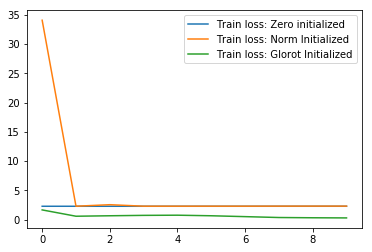

In [42]:
#Zero Weight Initialization
print "Zero weight initialization"
lr=1e-4
ZeroInitNet = MLP_MNIST([28*28,500,200],10)
params = list(ZeroInitNet.parameters())
for p in params:
    nn.init.uniform(p,0,0)
    
zero_losses = init_train(ZeroInitNet,mnist_train,lr,128)

print "Normal weight initialization mean of zero, variance of 1"
lr=1e-3
NormInitNet = MLP_MNIST([28*28,500,200],10)
params = list(NormInitNet.parameters())
for p in params:
    if len(p.size()) > 1:
        nn.init.normal(p,0,1)
    else:
        nn.init.uniform(p,0,0)
norm_losses = init_train(NormInitNet,mnist_train,lr,128)

print " Glorot Initialization"
lr=1e-5
GlorotInitNet = MLP_MNIST([28*28,500,200],10)
GlorotInit_Net = GlorotInitialize(GlorotInitNet)
glorot_losses = init_train(GlorotInit_Net,mnist_train,lr,128)

plt.plot(zero_losses,label='Train loss: Zero initialized ')
plt.plot(norm_losses,label='Train loss: Norm Initialized')
plt.plot(glorot_losses,label='Train loss: Glorot Initialized')
plt.legend()
plt.show()
    

## 1.A.2 Initialization Comments
First it should be noted that the loss remains unchanged when using 0 weight intialization.  This can be attributed to the fact that each neuron will output the same value during forward propagatio and receive the same gradient during back propagation. When considering back propagation, each neuron will follow the same gradient and change identically. Thus the network will not learn.

Second, when intializing values using a normal distribution, the intial loss is very high. This is because the weight values can be quite high and lead to very strong incorrect predictions. Furthermore,the intialization values will increase the variance of the outputs during forward propagation, and the variance of the gradiant during backwards propagation. While the network will learn, it will learn more slowly than if initialized using Glorot initialization. Which is visible in the 10 epochs shown here.

Finally, Glorot initialization performed the best overall.  The network can rapidly learn parameters to reduce the empirical risk, very quickly.

# 1.B Learning Curves

In [12]:
#returns the best instance in training of the model to be trained as well as the loss and accuracy
#for both train and val if available.
def train(model, num_epochs,trainLoader,optimizer,valLoader=None, testLoader = None, verbose=True):
    bestValAcc = 0
    bestNetwork = 0
    train_accuracy = []
    val_accuracy = []
    test_accuracy = []
    epoch_loss=[0]*num_epochs
    loss_crit = nn.CrossEntropyLoss()
    for epoch in range(num_epochs):
        losses = []
        correct = 0
        total = 0
        val_correct = 0
        val_total = 0
        test_correct = 0
        test_total = 0
        model.train()
        for batch_index, (inputs, targets) in enumerate(trainLoader):
            x, targets = Variable(inputs.view([-1,model.insize])), Variable(targets)

            logits = model.forward(x)
            _, preds = model.prediction(logits)
            correct += preds.eq(targets.data).sum()
            total += targets.size(0)
            loss = loss_crit(logits,targets)

            loss.backward()
            optimizer.step()
            losses.append(loss.data[0])
        epoch_loss[epoch] = np.mean(losses)
        train_accuracy.append(correct/float(total))
        
        if (valLoader != None):
            model.eval()
            for batch_index,(inputs,targets) in enumerate(valLoader):
                x, targets = Variable(inputs.view([-1,model.insize])), Variable(targets)

                logits = model.forward(x)
                _, preds = model.prediction(logits)
                val_correct += preds.eq(targets.data).sum()
                val_total += targets.size(0)
            val_acc = (val_correct/float(val_total))
            val_accuracy.append(val_acc)
                            
            if val_acc > bestValAcc:
                bestNetwork = model
                bestValAcc= val_acc
                
                
        if (testLoader != None):
            model.eval()
            for batch_index,(inputs,targets) in enumerate(testLoader):
                x, targets = Variable(inputs.view([-1,model.insize])), Variable(targets)

                logits = model.forward(x)
                _, preds = model.prediction(logits)
                test_correct += preds.eq(targets.data).sum()
                test_total += targets.size(0)
            test_acc = (test_correct/float(test_total))
            test_accuracy.append(test_acc)
            
        if (valLoader != None and testLoader != None and verbose == True and epoch%20==0):
            print('Epoch : %d Loss : %.3f  Train Accuracy: %.3f Validation Accuracy: %.3f Test Accuracy: %.3f' % (epoch+1,epoch_loss[epoch],\
                                                                                                                  train_accuracy[epoch], val_accuracy[epoch], test_accuracy[epoch]))
        elif (valLoader != None and testLoader == None and verbose == True and epoch%20==0):
            print('Epoch : %d Loss : %.3f  Train Accuracy: %.3f Validation Accuracy: %.3f' % (epoch+1,epoch_loss[epoch],\
                                                                                              train_accuracy[epoch], val_accuracy[epoch]))
        elif (verbose == True and epoch%20==0):
            print('Epoch : %d Loss : %.3f  Train Accuracy: %.3f' %(epoch+1, epoch_loss[epoch], train_accuracy[epoch]))
    return (bestNetwork, epoch_loss, train_accuracy, val_accuracy, test_accuracy)
    

            
def hyperparamsearch(num_epochs, hparams, trainLoader, valLoader, testLoader = None,verbose=True):
    bestNetwork = 0
    bestValAcc = 0
    for layer in hparams['layers']:
        for lr in hparams['lr']:
            for decay in hparams['lr_decay']:
                print "Neural Net Hyper params:"
                print "Layers: " + repr(layer)
                print "Learning Rate: " + repr(lr)
                print "Learning rate decay: " + repr(decay)
                epoch_loss = [0] * num_epochs
                NeuralNet = MLP_MNIST(layer,10)
                NeuralNet = GlorotInitialize(NeuralNet)
                optimizer = torch.optim.Adagrad(NeuralNet.parameters(), lr=lr,lr_decay = decay)

                    
                network, loss_history, train_accuracy, val_accuracy,test_accuracy = train(NeuralNet,num_epochs, trainLoader,optimizer,valLoader,verbose)
                if (max(val_accuracy) > bestValAcc):
                    bestNetwork = network
                    bestValAcc = max(val_accuracy)
                plt.plot(train_accuracy, label='Train accuracy')
                plt.plot(val_accuracy, label = 'Validation Accuracy')
                if (testLoader != None):
                    plt.plot(test_accuracy, label = 'Test Accuracy')
                plt.legend()
                plt.show()
                    
    return bestNetwork, bestValAcc

## 1.B.2 Hyperparameter Search

Below we perform hyper parameter search on the size of the hidden layers, the learning rate, and the learning rate decay. Each model uses batch sizes of 64 during training, and has a Rectified Linear unit as the non-linearity.

In each of the plots below, the orange curve is the training accuracy and the blue curve is the validation accuracy.

Neural Net Hyper params:
Layers: [784, 500, 250]
Learning Rate: 0.001
Learning rate decay: 0.0001
Epoch : 1 Loss : 0.261  Train Accuracy: 0.924 Validation Accuracy: 0.963
Epoch : 2 Loss : 0.102  Train Accuracy: 0.968 Validation Accuracy: 0.971
Epoch : 3 Loss : 0.063  Train Accuracy: 0.980 Validation Accuracy: 0.973
Epoch : 4 Loss : 0.045  Train Accuracy: 0.986 Validation Accuracy: 0.973
Epoch : 5 Loss : 0.029  Train Accuracy: 0.991 Validation Accuracy: 0.976
Epoch : 6 Loss : 0.020  Train Accuracy: 0.993 Validation Accuracy: 0.976
Epoch : 7 Loss : 0.015  Train Accuracy: 0.996 Validation Accuracy: 0.974
Epoch : 8 Loss : 0.010  Train Accuracy: 0.997 Validation Accuracy: 0.977
Epoch : 9 Loss : 0.007  Train Accuracy: 0.998 Validation Accuracy: 0.978
Epoch : 10 Loss : 0.005  Train Accuracy: 0.998 Validation Accuracy: 0.979
Epoch : 11 Loss : 0.004  Train Accuracy: 0.999 Validation Accuracy: 0.978
Epoch : 12 Loss : 0.002  Train Accuracy: 0.999 Validation Accuracy: 0.977
Epoch : 13 Loss : 0.002

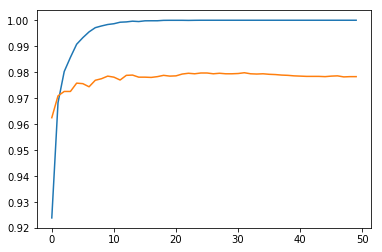

Neural Net Hyper params:
Layers: [784, 500, 250]
Learning Rate: 0.0001
Learning rate decay: 0.0001
Epoch : 1 Loss : 0.930  Train Accuracy: 0.790 Validation Accuracy: 0.886
Epoch : 2 Loss : 0.405  Train Accuracy: 0.886 Validation Accuracy: 0.909
Epoch : 3 Loss : 0.330  Train Accuracy: 0.904 Validation Accuracy: 0.920
Epoch : 4 Loss : 0.297  Train Accuracy: 0.914 Validation Accuracy: 0.925
Epoch : 5 Loss : 0.273  Train Accuracy: 0.921 Validation Accuracy: 0.930
Epoch : 6 Loss : 0.256  Train Accuracy: 0.926 Validation Accuracy: 0.934
Epoch : 7 Loss : 0.241  Train Accuracy: 0.931 Validation Accuracy: 0.937
Epoch : 8 Loss : 0.229  Train Accuracy: 0.934 Validation Accuracy: 0.939
Epoch : 9 Loss : 0.219  Train Accuracy: 0.937 Validation Accuracy: 0.941
Epoch : 10 Loss : 0.210  Train Accuracy: 0.940 Validation Accuracy: 0.943
Epoch : 11 Loss : 0.203  Train Accuracy: 0.942 Validation Accuracy: 0.945
Epoch : 12 Loss : 0.196  Train Accuracy: 0.944 Validation Accuracy: 0.946
Epoch : 13 Loss : 0.19

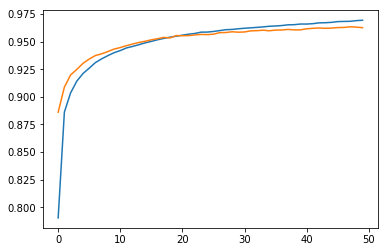

Neural Net Hyper params:
Layers: [784, 500, 250]
Learning Rate: 1e-05
Learning rate decay: 0.0001
Epoch : 1 Loss : 2.125  Train Accuracy: 0.273 Validation Accuracy: 0.431
Epoch : 2 Loss : 1.970  Train Accuracy: 0.504 Validation Accuracy: 0.595
Epoch : 3 Loss : 1.876  Train Accuracy: 0.609 Validation Accuracy: 0.667
Epoch : 4 Loss : 1.804  Train Accuracy: 0.662 Validation Accuracy: 0.704
Epoch : 5 Loss : 1.745  Train Accuracy: 0.690 Validation Accuracy: 0.729
Epoch : 6 Loss : 1.695  Train Accuracy: 0.709 Validation Accuracy: 0.744
Epoch : 7 Loss : 1.652  Train Accuracy: 0.723 Validation Accuracy: 0.755
Epoch : 8 Loss : 1.613  Train Accuracy: 0.734 Validation Accuracy: 0.764
Epoch : 9 Loss : 1.579  Train Accuracy: 0.743 Validation Accuracy: 0.772
Epoch : 10 Loss : 1.549  Train Accuracy: 0.750 Validation Accuracy: 0.777
Epoch : 11 Loss : 1.521  Train Accuracy: 0.755 Validation Accuracy: 0.783
Epoch : 12 Loss : 1.496  Train Accuracy: 0.760 Validation Accuracy: 0.788
Epoch : 13 Loss : 1.473

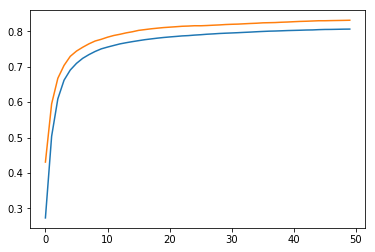

Neural Net Hyper params:
Layers: [784, 500, 500]
Learning Rate: 0.001
Learning rate decay: 0.0001
Epoch : 1 Loss : 0.242  Train Accuracy: 0.927 Validation Accuracy: 0.957
Epoch : 2 Loss : 0.093  Train Accuracy: 0.972 Validation Accuracy: 0.972
Epoch : 3 Loss : 0.052  Train Accuracy: 0.984 Validation Accuracy: 0.974
Epoch : 4 Loss : 0.034  Train Accuracy: 0.989 Validation Accuracy: 0.975
Epoch : 5 Loss : 0.023  Train Accuracy: 0.992 Validation Accuracy: 0.975
Epoch : 6 Loss : 0.015  Train Accuracy: 0.995 Validation Accuracy: 0.979
Epoch : 7 Loss : 0.011  Train Accuracy: 0.997 Validation Accuracy: 0.978
Epoch : 8 Loss : 0.007  Train Accuracy: 0.997 Validation Accuracy: 0.978
Epoch : 9 Loss : 0.004  Train Accuracy: 0.999 Validation Accuracy: 0.978
Epoch : 10 Loss : 0.003  Train Accuracy: 0.999 Validation Accuracy: 0.979
Epoch : 11 Loss : 0.002  Train Accuracy: 0.999 Validation Accuracy: 0.978
Epoch : 12 Loss : 0.002  Train Accuracy: 1.000 Validation Accuracy: 0.979
Epoch : 13 Loss : 0.001

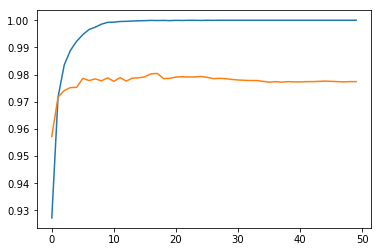

Neural Net Hyper params:
Layers: [784, 500, 500]
Learning Rate: 0.0001
Learning rate decay: 0.0001
Epoch : 1 Loss : 0.793  Train Accuracy: 0.818 Validation Accuracy: 0.896
Epoch : 2 Loss : 0.352  Train Accuracy: 0.898 Validation Accuracy: 0.915
Epoch : 3 Loss : 0.295  Train Accuracy: 0.914 Validation Accuracy: 0.927
Epoch : 4 Loss : 0.265  Train Accuracy: 0.924 Validation Accuracy: 0.932
Epoch : 5 Loss : 0.243  Train Accuracy: 0.930 Validation Accuracy: 0.936
Epoch : 6 Loss : 0.226  Train Accuracy: 0.935 Validation Accuracy: 0.941
Epoch : 7 Loss : 0.213  Train Accuracy: 0.939 Validation Accuracy: 0.942
Epoch : 8 Loss : 0.202  Train Accuracy: 0.942 Validation Accuracy: 0.945
Epoch : 9 Loss : 0.191  Train Accuracy: 0.945 Validation Accuracy: 0.947
Epoch : 10 Loss : 0.181  Train Accuracy: 0.948 Validation Accuracy: 0.951
Epoch : 11 Loss : 0.172  Train Accuracy: 0.951 Validation Accuracy: 0.953
Epoch : 12 Loss : 0.165  Train Accuracy: 0.952 Validation Accuracy: 0.954
Epoch : 13 Loss : 0.15

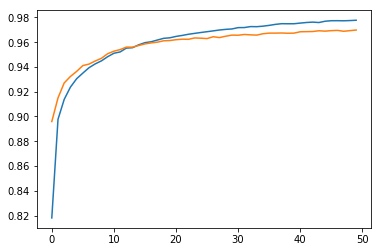

Neural Net Hyper params:
Layers: [784, 500, 500]
Learning Rate: 1e-05
Learning rate decay: 0.0001
Epoch : 1 Loss : 2.121  Train Accuracy: 0.360 Validation Accuracy: 0.544
Epoch : 2 Loss : 1.944  Train Accuracy: 0.589 Validation Accuracy: 0.663
Epoch : 3 Loss : 1.836  Train Accuracy: 0.663 Validation Accuracy: 0.708
Epoch : 4 Loss : 1.753  Train Accuracy: 0.697 Validation Accuracy: 0.734
Epoch : 5 Loss : 1.685  Train Accuracy: 0.719 Validation Accuracy: 0.752
Epoch : 6 Loss : 1.628  Train Accuracy: 0.734 Validation Accuracy: 0.764
Epoch : 7 Loss : 1.578  Train Accuracy: 0.745 Validation Accuracy: 0.774
Epoch : 8 Loss : 1.535  Train Accuracy: 0.753 Validation Accuracy: 0.781
Epoch : 9 Loss : 1.496  Train Accuracy: 0.759 Validation Accuracy: 0.788
Epoch : 10 Loss : 1.462  Train Accuracy: 0.764 Validation Accuracy: 0.792
Epoch : 11 Loss : 1.431  Train Accuracy: 0.769 Validation Accuracy: 0.796
Epoch : 12 Loss : 1.403  Train Accuracy: 0.773 Validation Accuracy: 0.800
Epoch : 13 Loss : 1.377

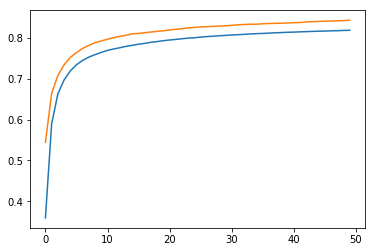

Neural Net Hyper params:
Layers: [784, 650, 650]
Learning Rate: 0.001
Learning rate decay: 0.0001
Epoch : 1 Loss : 0.227  Train Accuracy: 0.932 Validation Accuracy: 0.963
Epoch : 2 Loss : 0.085  Train Accuracy: 0.974 Validation Accuracy: 0.971
Epoch : 3 Loss : 0.052  Train Accuracy: 0.984 Validation Accuracy: 0.975
Epoch : 4 Loss : 0.032  Train Accuracy: 0.990 Validation Accuracy: 0.978
Epoch : 5 Loss : 0.021  Train Accuracy: 0.993 Validation Accuracy: 0.976
Epoch : 6 Loss : 0.015  Train Accuracy: 0.995 Validation Accuracy: 0.978
Epoch : 7 Loss : 0.010  Train Accuracy: 0.997 Validation Accuracy: 0.978
Epoch : 8 Loss : 0.007  Train Accuracy: 0.997 Validation Accuracy: 0.978
Epoch : 9 Loss : 0.005  Train Accuracy: 0.998 Validation Accuracy: 0.978
Epoch : 10 Loss : 0.003  Train Accuracy: 0.999 Validation Accuracy: 0.979
Epoch : 11 Loss : 0.003  Train Accuracy: 0.999 Validation Accuracy: 0.980
Epoch : 12 Loss : 0.002  Train Accuracy: 0.999 Validation Accuracy: 0.978
Epoch : 13 Loss : 0.002

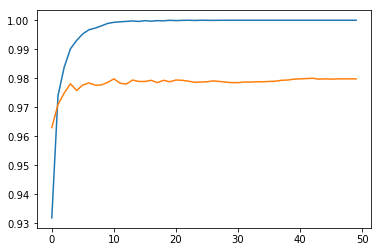

Neural Net Hyper params:
Layers: [784, 650, 650]
Learning Rate: 0.0001
Learning rate decay: 0.0001
Epoch : 1 Loss : 0.672  Train Accuracy: 0.843 Validation Accuracy: 0.909
Epoch : 2 Loss : 0.313  Train Accuracy: 0.909 Validation Accuracy: 0.927
Epoch : 3 Loss : 0.270  Train Accuracy: 0.923 Validation Accuracy: 0.934
Epoch : 4 Loss : 0.239  Train Accuracy: 0.933 Validation Accuracy: 0.939
Epoch : 5 Loss : 0.216  Train Accuracy: 0.940 Validation Accuracy: 0.944
Epoch : 6 Loss : 0.201  Train Accuracy: 0.943 Validation Accuracy: 0.946
Epoch : 7 Loss : 0.187  Train Accuracy: 0.946 Validation Accuracy: 0.949
Epoch : 8 Loss : 0.172  Train Accuracy: 0.951 Validation Accuracy: 0.954
Epoch : 9 Loss : 0.160  Train Accuracy: 0.954 Validation Accuracy: 0.954
Epoch : 10 Loss : 0.149  Train Accuracy: 0.957 Validation Accuracy: 0.958
Epoch : 11 Loss : 0.142  Train Accuracy: 0.959 Validation Accuracy: 0.957
Epoch : 12 Loss : 0.135  Train Accuracy: 0.962 Validation Accuracy: 0.960
Epoch : 13 Loss : 0.12

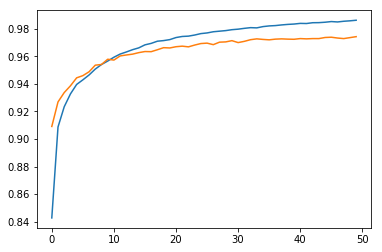

Neural Net Hyper params:
Layers: [784, 650, 650]
Learning Rate: 1e-05
Learning rate decay: 0.0001
Epoch : 1 Loss : 2.074  Train Accuracy: 0.443 Validation Accuracy: 0.651
Epoch : 2 Loss : 1.863  Train Accuracy: 0.673 Validation Accuracy: 0.729
Epoch : 3 Loss : 1.734  Train Accuracy: 0.719 Validation Accuracy: 0.759
Epoch : 4 Loss : 1.636  Train Accuracy: 0.741 Validation Accuracy: 0.773
Epoch : 5 Loss : 1.555  Train Accuracy: 0.756 Validation Accuracy: 0.786
Epoch : 6 Loss : 1.487  Train Accuracy: 0.767 Validation Accuracy: 0.795
Epoch : 7 Loss : 1.429  Train Accuracy: 0.775 Validation Accuracy: 0.801
Epoch : 8 Loss : 1.378  Train Accuracy: 0.782 Validation Accuracy: 0.806
Epoch : 9 Loss : 1.334  Train Accuracy: 0.786 Validation Accuracy: 0.811
Epoch : 10 Loss : 1.294  Train Accuracy: 0.791 Validation Accuracy: 0.815
Epoch : 11 Loss : 1.259  Train Accuracy: 0.794 Validation Accuracy: 0.818
Epoch : 12 Loss : 1.227  Train Accuracy: 0.797 Validation Accuracy: 0.820
Epoch : 13 Loss : 1.198

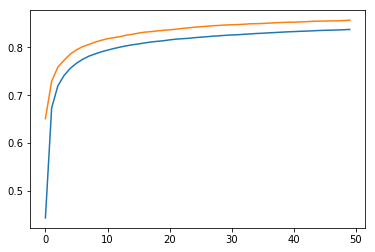

In [152]:
#Hyper parameter search

hparams = {
    "layers": [[28*28,500,250], [28*28,500,500],[28*28,650,650]],
    "lr": [1e-3,1e-4,1e-5],
    "lr_decay": [10e-5]
}

bestModel, bestValAcc = hyperparamsearch(50, hparams, mnist_train, mnist_val,verbose=False)
                

In [153]:
print bestModel
print bestValAcc

MLP_MNIST(
  (fc1): Linear(in_features=784, out_features=500)
  (dropout1): Dropout(p=0.0)
  (fc2): Linear(in_features=500, out_features=500)
  (dropout2): Dropout(p=0.0)
  (fc3): Linear(in_features=500, out_features=10)
)
0.9804


### 1.B.2.2
The best model was had the following hyperparameters:
Hidden layers of size 500 units each, a batch size of 64, Rectified Linear units as nonlinearities.
Additionally the optimizer is an Adagrad optimizer with a learning rate 0.001 and a decay rate of 0.0001


## 1.B.3 Training the best model for 100 Epochs

The model is identical to that listed above, but is now trained twice as long.

In [154]:
#Training the best model for 100 epochs
layers = [784, 500, 500]
lr = 0.001
lr_decay=0.0001
model = MLP_MNIST(layers,10)
model = GlorotInitialize(model)
optimizer = torch.optim.Adagrad(model.parameters(), lr=lr,lr_decay = lr_decay)
train_results = train(model,100,mnist_train,optimizer,mnist_val)

Epoch : 1 Loss : 0.253  Train Accuracy: 0.925 Validation Accuracy: 0.959
Epoch : 2 Loss : 0.095  Train Accuracy: 0.971 Validation Accuracy: 0.971
Epoch : 3 Loss : 0.055  Train Accuracy: 0.982 Validation Accuracy: 0.972
Epoch : 4 Loss : 0.035  Train Accuracy: 0.989 Validation Accuracy: 0.976
Epoch : 5 Loss : 0.022  Train Accuracy: 0.993 Validation Accuracy: 0.977
Epoch : 6 Loss : 0.015  Train Accuracy: 0.995 Validation Accuracy: 0.979
Epoch : 7 Loss : 0.010  Train Accuracy: 0.997 Validation Accuracy: 0.978
Epoch : 8 Loss : 0.006  Train Accuracy: 0.998 Validation Accuracy: 0.978
Epoch : 9 Loss : 0.005  Train Accuracy: 0.998 Validation Accuracy: 0.978
Epoch : 10 Loss : 0.002  Train Accuracy: 0.999 Validation Accuracy: 0.978
Epoch : 11 Loss : 0.002  Train Accuracy: 0.999 Validation Accuracy: 0.978
Epoch : 12 Loss : 0.002  Train Accuracy: 1.000 Validation Accuracy: 0.979
Epoch : 13 Loss : 0.001  Train Accuracy: 1.000 Validation Accuracy: 0.979
Epoch : 14 Loss : 0.001  Train Accuracy: 1.000 

MLP_MNIST(
  (fc1): Linear(in_features=784, out_features=500)
  (dropout1): Dropout(p=0.0)
  (fc2): Linear(in_features=500, out_features=500)
  (dropout2): Dropout(p=0.0)
  (fc3): Linear(in_features=500, out_features=10)
)


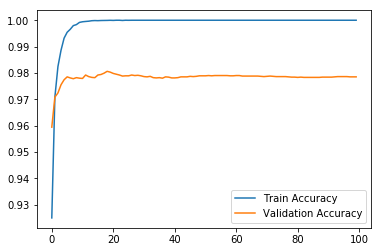

In [155]:
(bestNetwork, epoch_loss, train_accuracy, val_accuracy, test_accuracy) = train_results

print bestNetwork

plt.plot(train_accuracy, label = 'Train Accuracy')
plt.plot(val_accuracy, label= 'Validation Accuracy')
plt.legend()
plt.show()

## 1.B.4 Doubling the number of parameters

In [159]:
print 'Best validation accuracy: ' + repr(bestValAcc)
print 'Best model: ' + repr(bestModel)
params = list(bestModel.parameters())
sum_params=0
for p in params:
    print p.size()
    if len(p.size()) > 1:
        sum_params += p.size()[0]*p.size()[1]
    else:
        sum_params += p.size()[0]
print ('Total number of parameters in best model: %d' %sum_params)
print 2*sum_params

Best validation accuracy: 0.9804
Best model: MLP_MNIST(
  (fc1): Linear(in_features=784, out_features=500)
  (dropout1): Dropout(p=0.0)
  (fc2): Linear(in_features=500, out_features=500)
  (dropout2): Dropout(p=0.0)
  (fc3): Linear(in_features=500, out_features=10)
)
torch.Size([500, 784])
torch.Size([500])
torch.Size([500, 500])
torch.Size([500])
torch.Size([10, 500])
torch.Size([10])
Total number of parameters in best model: 648010
1296020


Currently there are: (784+(784*500) + 800+(800*450)+ (450*10)+450+ 10) = 992,960 parameters


(in_size+(in_size*size1) + size1 + (size1*size2) + size2 + (size2*outsize) + outsize

We would like to create a new model with twice as many parameters, 1,985,920 parameters.



In [165]:
layerDims = [784,1005,500]
lr=0.001
lr_decay = 0.0001
Double_NN = MLP_MNIST(layerDims,10)
params = list(Double_NN.parameters())
sum_params=0
for p in params:
    print p.size()
    if len(p.size()) > 1:
        sum_params += p.size()[0]*p.size()[1]
    else:
        sum_params += p.size()[0]
        
print ('Total number of parameters in double size model: %d' %sum_params)

torch.Size([1005, 784])
torch.Size([1005])
torch.Size([500, 1005])
torch.Size([500])
torch.Size([10, 500])
torch.Size([10])
Total number of parameters in double size model: 1296935


In [166]:
Double_NN = GlorotInitialize(Double_NN)
optimizer = torch.optim.Adagrad(Double_NN.parameters(), lr=lr,lr_decay=lr_decay)
(Double_NN, epoch_loss, double_train_accuracy, double_val_accuracy, double_test_acc) = train(Double_NN,100,mnist_train,optimizer,mnist_val)


Epoch : 1 Loss : 0.219  Train Accuracy: 0.934 Validation Accuracy: 0.967
Epoch : 2 Loss : 0.081  Train Accuracy: 0.975 Validation Accuracy: 0.975
Epoch : 3 Loss : 0.048  Train Accuracy: 0.985 Validation Accuracy: 0.974
Epoch : 4 Loss : 0.027  Train Accuracy: 0.991 Validation Accuracy: 0.976
Epoch : 5 Loss : 0.017  Train Accuracy: 0.994 Validation Accuracy: 0.977
Epoch : 6 Loss : 0.011  Train Accuracy: 0.996 Validation Accuracy: 0.979
Epoch : 7 Loss : 0.007  Train Accuracy: 0.997 Validation Accuracy: 0.980
Epoch : 8 Loss : 0.003  Train Accuracy: 0.999 Validation Accuracy: 0.979
Epoch : 9 Loss : 0.003  Train Accuracy: 0.999 Validation Accuracy: 0.978
Epoch : 10 Loss : 0.002  Train Accuracy: 0.999 Validation Accuracy: 0.980
Epoch : 11 Loss : 0.002  Train Accuracy: 0.999 Validation Accuracy: 0.980
Epoch : 12 Loss : 0.001  Train Accuracy: 1.000 Validation Accuracy: 0.978
Epoch : 13 Loss : 0.001  Train Accuracy: 1.000 Validation Accuracy: 0.978
Epoch : 14 Loss : 0.000  Train Accuracy: 1.000 

In [167]:
print max(double_val_accuracy)

0.98


## 1.B.5 Why does a network with double the size perform worse on the validation set?

We see that while close, the smaller network performs better than the larger network by .04%.  This can be attributed to the increased capacity of the model.
Here we have not increased regularization within the network, in fact both networks have no regularization at all.  By doubling the capacity of the model, we have also increased the inherent variance found within the trained model. It is now more prone to overfitting than a smaller model.  While the error from bias may have been reduced, the model now has an increased error from variance. The increase in variance error, is larger than the decrease of bias error. This is known as the bias-variance tradeoff.

# Training Set Size, Generalization Gap, and Standard Error

First we'll randomly sample subsets of the training data. For each subsample we will train a model with the following hyperparameters:

Batch size = 64
Model architecture: 2 hidden layers, each with 500 neurons.
Non-linearities: Rectivfied Linear Units
Learning Rate: 0.001
Learning rate decay: 0.0001


In [20]:
alphas = [0.01,0.02,0.05,0.1,1.0]
TRAINSIZE = mnist_train_data.shape[0]
indices = list(range(TRAINSIZE))

#Hyperparameters for model
layerDims = [784,500,500]
lr=0.001
lr_decay = .0001
batch_size=64
repeat_test_results = [{}]*5
generalization_gap = [0]*5
for alpha in alphas:
    print "Alpha: " +repr(alpha)
    for i in range(0,5):  
        print "Test number: " + repr(i+1)
        subindices = np.random.choice(indices,size=[int(alpha*TRAINSIZE)])
        train_data_subset = mnist_train_data[subindices,:]
        train_labels_subset = mnist_train_labels[subindices]
        train_data_tensor = torch.utils.data.TensorDataset(torch.Tensor(train_data_subset),torch.IntTensor(train_labels_subset))

        subtrainloader = torch.utils.data.DataLoader(train_data_tensor, batch_size=batch_size, shuffle=True, num_workers=2)
        model = MLP_MNIST(layerDims,10)
        optimizer = torch.optim.Adagrad(model.parameters(),lr=lr, lr_decay=lr_decay)
        test_results = train(model,100,subtrainloader,optimizer,mnist_val,mnist_test,verbose=True)
        bestNetwork, epoch_loss, train_accuracy, val_accuracy, test_accuracy = test_results
        best_epoch = int(np.argmax(val_accuracy))
        generalization_gap[i] = train_accuracy[best_epoch] - test_accuracy[best_epoch]
        print "Generalization gap for test: " + repr(generalization_gap[i])
    print ("Average generalization gap for alpha:  %.2f:  %.4f" %(alpha, np.mean(generalization_gap)))

Alpha: 0.01
Test number: 1
Epoch : 1 Loss : 2.205  Train Accuracy: 0.318 Validation Accuracy: 0.397 Test Accuracy: 0.400
Epoch : 21 Loss : 0.019  Train Accuracy: 0.998 Validation Accuracy: 0.867 Test Accuracy: 0.861
Epoch : 41 Loss : 0.001  Train Accuracy: 1.000 Validation Accuracy: 0.859 Test Accuracy: 0.857
Epoch : 61 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.865 Test Accuracy: 0.863
Epoch : 81 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.864 Test Accuracy: 0.860
Generalization gap for test: 0.12190000000000001
Test number: 2
Epoch : 1 Loss : 2.185  Train Accuracy: 0.318 Validation Accuracy: 0.522 Test Accuracy: 0.522
Epoch : 21 Loss : 0.014  Train Accuracy: 1.000 Validation Accuracy: 0.855 Test Accuracy: 0.854
Epoch : 41 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.840 Test Accuracy: 0.840
Epoch : 61 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.839 Test Accuracy: 0.838
Epoch : 81 Loss : 0.000  Train Accuracy: 1.000 Validatio

Epoch : 1 Loss : 0.997  Train Accuracy: 0.744 Validation Accuracy: 0.853 Test Accuracy: 0.846
Epoch : 21 Loss : 0.005  Train Accuracy: 0.999 Validation Accuracy: 0.939 Test Accuracy: 0.937
Epoch : 41 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.940 Test Accuracy: 0.938
Epoch : 61 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.940 Test Accuracy: 0.936
Epoch : 81 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.939 Test Accuracy: 0.934
Generalization gap for test: 0.060799999999999965
Test number: 2
Epoch : 1 Loss : 0.993  Train Accuracy: 0.725 Validation Accuracy: 0.880 Test Accuracy: 0.871
Epoch : 21 Loss : 0.010  Train Accuracy: 0.997 Validation Accuracy: 0.938 Test Accuracy: 0.937
Epoch : 41 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.944 Test Accuracy: 0.941
Epoch : 61 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.943 Test Accuracy: 0.939
Epoch : 81 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.942 Test Acc

### 1.C.3 Results of Generalization Gap Experiment

| Alpha  | Result 1 | Result 2 |  Result 3 |  Result 4 |  Result 5 | Average | Standard Error |
|--------|----------|----------|-----------|-----------|-----------|---------|----------------|
|  0.01  |   12.2%  |   10.8%  |  10.1%    |   9.00%   |   13.7%   |  11.17% |    0.0164      |
|  0.02  |   9.30%  |   7.5%   |  7.8%     |   5.6%    |   12.2%   |  8.48%  |    0.0220      |
|  0.05  |   8.6%   |   8.2%   |  8.7%     |  8.6%     |   8.2%    |  8.43%  |    0.0022      |
|  0.1   |   6.0%   |   5.9%   |  6.3%     |  6.3%     |  6.3%     |  6.16%  |    0.0017      |
|  1.0   |   2.6%   |   3.00%  |  2.61%    |  2.7%     |  2.8%     |  2.75%  |    0.0015      |

### 1.C.4 Comments about results

First, it should be noted that the average of the generalization gap decreases as more of the dataset is used to train the model.  This follows from the ability of a model to generalize better as data is increased.  Additionally, on small amounts of data, the model is very likely to overfit and therefore generalize worse overall, when compared to using larger amounts of data.

Also, it can be seen that generally the standard error of the Generalization gap decreases. This is because more data acts as a regularizer, thus decreasing the variance of the model overall. As such, the model is more likely to generalize similarily well when more data is used to train it. 

# Problem 2

In [3]:
from sklearn.preprocessing import StandardScaler

import numpy as np
data = np.loadtxt('./data/20news-bydate/matlab/train.data')
labels = np.loadtxt('./data/20news-bydate/matlab/train.label')
labels -= 1

test_data = np.loadtxt('./data/20news-bydate/matlab/test.data')
test_labels = np.loadtxt('./data/20news-bydate/matlab/test.label')
test_labels -= 1

In [4]:
class MLP_20(nn.Module):
    
    def __init__(self,insize,outsize):
        super(MLP_20,self).__init__()
        self.fc1 = nn.Linear(insize,100)
        self.fc2 = nn.Linear(100,outsize)
        self.insize = insize
        
    def forward(self,x):
        a1 = self.fc1(x)
        h1 = nn.functional.relu(a1)
        
        logits = self.fc2(h1)
        
        return logits
    
    def prediction(self,logits):
        
        values, indices = torch.max(logits.data,1)
        
        return values, indices


In [5]:
def restructure_data(data):
    samples, vocab_size, max_word_count = np.max(data,axis=0)
    restructured_data = np.zeros((int(samples),int(vocab_size)))
    for i in range(len(data)):
        if (data[i,1]-1)<=vocab_size:
            restructured_data[int(data[i,0]-1),int(data[i,1]-1)]=data[i,2]
    return restructured_data

def tfidf(data):
    idf =  np.log(np.divide((data.shape[0]*np.ones_like(data)),1+np.sum(np.equal(data>0,1),axis=0)[None,:].astype(np.float)))
    return np.multiply(data,idf)

def make_loaders(data,labels,val_split,test_data=None,test_labels=None,batch_size=128):
    val_loader = 0
    indices = np.arange(data.shape[0])
    np.random.shuffle(indices)
    split = int(val_split*indices.shape[0])
    train_data, val_data = data[indices[:split],:], data[indices[split:],:]
    train_labels, val_labels = labels[indices[:split]], labels[indices[split:]]
    del indices
    print train_data.shape, train_labels.shape
    print val_data.shape, val_labels.shape
    
    train_tensor = torch.utils.data.TensorDataset(torch.Tensor(train_data),torch.IntTensor(train_labels))
    del train_data
    del train_labels
    train_loader = torch.utils.data.DataLoader(train_tensor,batch_size=batch_size, shuffle = True)
    del train_tensor
    if val_split<1:
        val_tensor = torch.utils.data.TensorDataset(torch.Tensor(val_data), torch.IntTensor(val_labels))
        del val_data
        del val_labels
        val_loader = torch.utils.data.DataLoader(val_tensor,batch_size=batch_size, shuffle = True)
        del val_tensor
        
    if (type(test_data) != type(None)):
        test_tensor = torch.utils.data.TensorDataset(torch.Tensor(test_data),torch.IntTensor(test_labels))
        test_loader = torch.utils.data.DataLoader(test_tensor,batch_size=batch_size, shuffle = True)
        return train_loader, val_loader, test_loader

    return train_loader, val_loader


def standardize_data(data):
    s = StandardScaler()
    s.fit(data)
    s.var_ += 1e-5
    standardized_data = s.transform(data)
    return standardized_data

In [7]:
data = restructure_data(data)
Vocab_size = data.shape[1]
test_data = restructure_data(test_data)[:,:Vocab_size]
print test_data.shape

(11269, 53975)
(7505, 61188)
(7505, 53975)


(11269, 53975)
(7505, 61188)
(9015, 53975) (9015,)
(2254, 53975) (2254,)
Learning rate: 1e-06
Epoch : 1 Loss : 3.018  Train Accuracy: 0.046 Validation Accuracy: 0.067 Test Accuracy: 0.061
Epoch : 2 Loss : 2.988  Train Accuracy: 0.061 Validation Accuracy: 0.070 Test Accuracy: 0.068
Epoch : 3 Loss : 2.957  Train Accuracy: 0.076 Validation Accuracy: 0.098 Test Accuracy: 0.089
Epoch : 4 Loss : 2.919  Train Accuracy: 0.121 Validation Accuracy: 0.143 Test Accuracy: 0.120
Epoch : 5 Loss : 2.872  Train Accuracy: 0.147 Validation Accuracy: 0.155 Test Accuracy: 0.136
Epoch : 6 Loss : 2.828  Train Accuracy: 0.161 Validation Accuracy: 0.180 Test Accuracy: 0.169
Epoch : 7 Loss : 2.758  Train Accuracy: 0.225 Validation Accuracy: 0.219 Test Accuracy: 0.200
Epoch : 8 Loss : 2.699  Train Accuracy: 0.257 Validation Accuracy: 0.255 Test Accuracy: 0.223
Epoch : 9 Loss : 2.621  Train Accuracy: 0.306 Validation Accuracy: 0.311 Test Accuracy: 0.263
Epoch : 10 Loss : 2.581  Train Accuracy: 0.314 Validation Ac

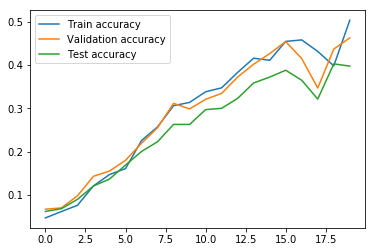

Learning rate: 1e-07
Epoch : 1 Loss : 3.030  Train Accuracy: 0.040 Validation Accuracy: 0.042 Test Accuracy: 0.040
Epoch : 2 Loss : 3.007  Train Accuracy: 0.040 Validation Accuracy: 0.049 Test Accuracy: 0.042
Epoch : 3 Loss : 2.993  Train Accuracy: 0.045 Validation Accuracy: 0.063 Test Accuracy: 0.049
Epoch : 4 Loss : 2.983  Train Accuracy: 0.053 Validation Accuracy: 0.070 Test Accuracy: 0.053
Epoch : 5 Loss : 2.975  Train Accuracy: 0.061 Validation Accuracy: 0.071 Test Accuracy: 0.055
Epoch : 6 Loss : 2.965  Train Accuracy: 0.064 Validation Accuracy: 0.072 Test Accuracy: 0.060
Epoch : 7 Loss : 2.953  Train Accuracy: 0.071 Validation Accuracy: 0.083 Test Accuracy: 0.065
Epoch : 8 Loss : 2.941  Train Accuracy: 0.080 Validation Accuracy: 0.086 Test Accuracy: 0.074
Epoch : 9 Loss : 2.932  Train Accuracy: 0.092 Validation Accuracy: 0.102 Test Accuracy: 0.083
Epoch : 10 Loss : 2.922  Train Accuracy: 0.106 Validation Accuracy: 0.115 Test Accuracy: 0.095
Epoch : 11 Loss : 2.909  Train Accurac

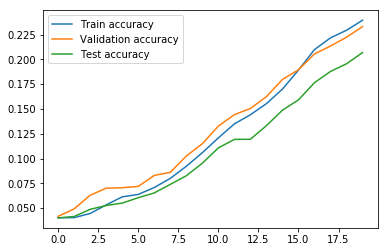

Learning rate: 1e-08
Epoch : 1 Loss : 3.043  Train Accuracy: 0.061 Validation Accuracy: 0.063 Test Accuracy: 0.064
Epoch : 2 Loss : 3.039  Train Accuracy: 0.063 Validation Accuracy: 0.064 Test Accuracy: 0.066
Epoch : 3 Loss : 3.033  Train Accuracy: 0.065 Validation Accuracy: 0.063 Test Accuracy: 0.067
Epoch : 4 Loss : 3.024  Train Accuracy: 0.064 Validation Accuracy: 0.064 Test Accuracy: 0.067
Epoch : 5 Loss : 3.016  Train Accuracy: 0.059 Validation Accuracy: 0.059 Test Accuracy: 0.064
Epoch : 6 Loss : 3.013  Train Accuracy: 0.054 Validation Accuracy: 0.053 Test Accuracy: 0.058
Epoch : 7 Loss : 3.010  Train Accuracy: 0.055 Validation Accuracy: 0.051 Test Accuracy: 0.054
Epoch : 8 Loss : 3.009  Train Accuracy: 0.056 Validation Accuracy: 0.050 Test Accuracy: 0.053
Epoch : 9 Loss : 3.007  Train Accuracy: 0.056 Validation Accuracy: 0.049 Test Accuracy: 0.052
Epoch : 10 Loss : 3.002  Train Accuracy: 0.057 Validation Accuracy: 0.049 Test Accuracy: 0.050
Epoch : 11 Loss : 2.998  Train Accurac

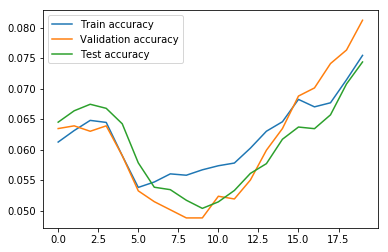

Learning rate: 1e-09
Epoch : 1 Loss : 3.007  Train Accuracy: 0.047 Validation Accuracy: 0.045 Test Accuracy: 0.053
Epoch : 2 Loss : 3.006  Train Accuracy: 0.047 Validation Accuracy: 0.045 Test Accuracy: 0.052
Epoch : 3 Loss : 3.005  Train Accuracy: 0.046 Validation Accuracy: 0.044 Test Accuracy: 0.053
Epoch : 4 Loss : 3.005  Train Accuracy: 0.047 Validation Accuracy: 0.044 Test Accuracy: 0.052
Epoch : 5 Loss : 3.004  Train Accuracy: 0.047 Validation Accuracy: 0.044 Test Accuracy: 0.052
Epoch : 6 Loss : 3.004  Train Accuracy: 0.047 Validation Accuracy: 0.045 Test Accuracy: 0.052
Epoch : 7 Loss : 3.002  Train Accuracy: 0.047 Validation Accuracy: 0.046 Test Accuracy: 0.053
Epoch : 8 Loss : 3.002  Train Accuracy: 0.048 Validation Accuracy: 0.047 Test Accuracy: 0.054
Epoch : 9 Loss : 3.001  Train Accuracy: 0.048 Validation Accuracy: 0.047 Test Accuracy: 0.054
Epoch : 10 Loss : 3.000  Train Accuracy: 0.051 Validation Accuracy: 0.049 Test Accuracy: 0.054
Epoch : 11 Loss : 2.998  Train Accurac

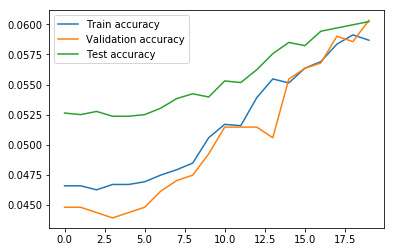

In [8]:
data = np.loadtxt('./data/20news-bydate/matlab/train.data')
labels = np.loadtxt('./data/20news-bydate/matlab/train.label')
labels -= 1

test_data = np.loadtxt('./data/20news-bydate/matlab/test.data')
test_labels = np.loadtxt('./data/20news-bydate/matlab/test.label')
test_labels -= 1

data = restructure_data(data)
Vocab_size = data.shape[1]
test_data = restructure_data(test_data)[:,:Vocab_size]


train_loader_newsgroups, val_loader_newsgroups, test_loader_newsgroups = make_loaders(data,labels,0.8,test_data,test_labels)
del data
del test_data


lrs = [1e-4,1e-5,1e-6,1e-7]
models = [0]*len(lrs)
train_results = [0]*len(lrs)
for i,lr in enumerate(lrs):
    print "Learning rate: " + repr(lr)
    models[i] = MLP_20(Vocab_size,20)
    models[i] = GlorotInitialize(models[i])
    optimizer = torch.optim.SGD(models[i].parameters(),lr=lr,momentum=0.9)
    loss_crit = nn.CrossEntropyLoss()
    train_results[i] = train(models[i],20,train_loader_newsgroups,optimizer,val_loader_newsgroups,test_loader_newsgroups)
    (bestNetwork, epoch_loss, train_accuracy, val_accuracy, test_accuracy) = train_results[i]
    
    plt.plot(train_accuracy, label='Train accuracy')
    plt.plot(val_accuracy, label='Validation accuracy')
    plt.plot(test_accuracy, label='Test accuracy')
    plt.legend()
    plt.show()

In [8]:
#TF-IDF Preprocessing
data = np.loadtxt('./data/20news-bydate/matlab/train.data')
labels = np.loadtxt('./data/20news-bydate/matlab/train.label')
labels -= 1

test_data = np.loadtxt('./data/20news-bydate/matlab/test.data')
test_labels = np.loadtxt('./data/20news-bydate/matlab/test.label')
test_labels -= 1

data = restructure_data(data)
data = tfidf(data)
Vocab_size = data.shape[1]
test_data = restructure_data(test_data)[:,:Vocab_size]
test_data = tfidf(test_data)

train_loader_tfidf, val_loader_tfidf, test_loader_tfidf = make_loaders(data,labels,0.8,test_data,test_labels)
del data
del test_data

(11269, 53975)
(11269, 53975)
(7505, 61188)
(7505, 53975)
(9015, 53975) (9015,)
(2254, 53975) (2254,)


Learning rate: 0.001
Epoch : 1 Loss : 3.641  Train Accuracy: 0.463 Validation Accuracy: 0.545 Test Accuracy: 0.498
Epoch : 2 Loss : 23.806  Train Accuracy: 0.613 Validation Accuracy: 0.531 Test Accuracy: 0.444
Epoch : 3 Loss : 100.750  Train Accuracy: 0.616 Validation Accuracy: 0.513 Test Accuracy: 0.437
Epoch : 4 Loss : 299.960  Train Accuracy: 0.581 Validation Accuracy: 0.533 Test Accuracy: 0.460
Epoch : 5 Loss : 4742.845  Train Accuracy: 0.613 Validation Accuracy: 0.464 Test Accuracy: 0.395
Epoch : 6 Loss : 15556.319  Train Accuracy: 0.527 Validation Accuracy: 0.410 Test Accuracy: 0.344
Epoch : 7 Loss : 6818.882  Train Accuracy: 0.466 Validation Accuracy: 0.384 Test Accuracy: 0.334
Epoch : 8 Loss : 1285384.161  Train Accuracy: 0.424 Validation Accuracy: 0.340 Test Accuracy: 0.299
Epoch : 9 Loss : 759963.529  Train Accuracy: 0.382 Validation Accuracy: 0.331 Test Accuracy: 0.292
Epoch : 10 Loss : 374729.348  Train Accuracy: 0.391 Validation Accuracy: 0.354 Test Accuracy: 0.328
Epoch :

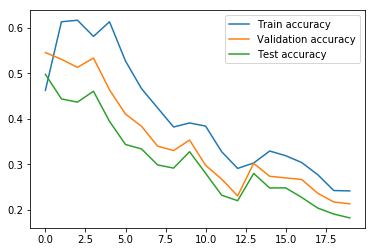

Learning rate: 0.0001
Epoch : 1 Loss : 2.398  Train Accuracy: 0.393 Validation Accuracy: 0.719 Test Accuracy: 0.640
Epoch : 2 Loss : 0.789  Train Accuracy: 0.842 Validation Accuracy: 0.783 Test Accuracy: 0.705
Epoch : 3 Loss : 1.435  Train Accuracy: 0.834 Validation Accuracy: 0.635 Test Accuracy: 0.541
Epoch : 4 Loss : 4.770  Train Accuracy: 0.773 Validation Accuracy: 0.737 Test Accuracy: 0.659
Epoch : 5 Loss : 2.866  Train Accuracy: 0.807 Validation Accuracy: 0.732 Test Accuracy: 0.624
Epoch : 6 Loss : 4.912  Train Accuracy: 0.748 Validation Accuracy: 0.633 Test Accuracy: 0.535
Epoch : 7 Loss : 13.443  Train Accuracy: 0.806 Validation Accuracy: 0.709 Test Accuracy: 0.602
Epoch : 8 Loss : 2.543  Train Accuracy: 0.818 Validation Accuracy: 0.741 Test Accuracy: 0.635
Epoch : 9 Loss : 3.095  Train Accuracy: 0.846 Validation Accuracy: 0.729 Test Accuracy: 0.614
Epoch : 10 Loss : 1.806  Train Accuracy: 0.897 Validation Accuracy: 0.733 Test Accuracy: 0.617
Epoch : 11 Loss : 12.957  Train Accu

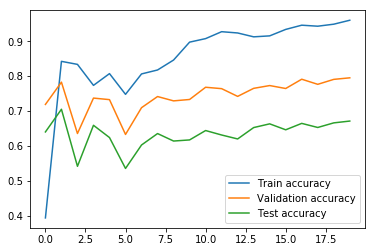

Learning rate: 1e-05
Epoch : 1 Loss : 2.955  Train Accuracy: 0.121 Validation Accuracy: 0.295 Test Accuracy: 0.259
Epoch : 2 Loss : 2.205  Train Accuracy: 0.567 Validation Accuracy: 0.659 Test Accuracy: 0.590
Epoch : 3 Loss : 1.359  Train Accuracy: 0.812 Validation Accuracy: 0.789 Test Accuracy: 0.714
Epoch : 4 Loss : 0.775  Train Accuracy: 0.874 Validation Accuracy: 0.825 Test Accuracy: 0.747
Epoch : 5 Loss : 0.483  Train Accuracy: 0.905 Validation Accuracy: 0.839 Test Accuracy: 0.754
Epoch : 6 Loss : 0.363  Train Accuracy: 0.917 Validation Accuracy: 0.841 Test Accuracy: 0.756
Epoch : 7 Loss : 0.294  Train Accuracy: 0.925 Validation Accuracy: 0.835 Test Accuracy: 0.757
Epoch : 8 Loss : 0.238  Train Accuracy: 0.942 Validation Accuracy: 0.854 Test Accuracy: 0.778
Epoch : 9 Loss : 0.222  Train Accuracy: 0.946 Validation Accuracy: 0.851 Test Accuracy: 0.769
Epoch : 10 Loss : 0.213  Train Accuracy: 0.952 Validation Accuracy: 0.805 Test Accuracy: 0.727
Epoch : 11 Loss : 0.261  Train Accurac

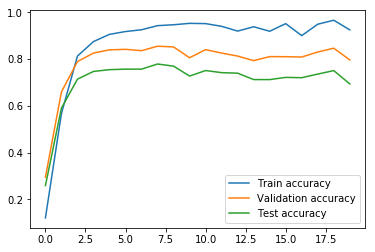

Learning rate: 1e-06
Epoch : 1 Loss : 3.117  Train Accuracy: 0.053 Validation Accuracy: 0.075 Test Accuracy: 0.062
Epoch : 2 Loss : 2.938  Train Accuracy: 0.104 Validation Accuracy: 0.153 Test Accuracy: 0.126
Epoch : 3 Loss : 2.720  Train Accuracy: 0.246 Validation Accuracy: 0.291 Test Accuracy: 0.246
Epoch : 4 Loss : 2.489  Train Accuracy: 0.433 Validation Accuracy: 0.442 Test Accuracy: 0.380
Epoch : 5 Loss : 2.234  Train Accuracy: 0.597 Validation Accuracy: 0.570 Test Accuracy: 0.497
Epoch : 6 Loss : 1.953  Train Accuracy: 0.705 Validation Accuracy: 0.654 Test Accuracy: 0.586
Epoch : 7 Loss : 1.659  Train Accuracy: 0.779 Validation Accuracy: 0.715 Test Accuracy: 0.645
Epoch : 8 Loss : 1.381  Train Accuracy: 0.825 Validation Accuracy: 0.755 Test Accuracy: 0.686
Epoch : 9 Loss : 1.141  Train Accuracy: 0.855 Validation Accuracy: 0.793 Test Accuracy: 0.712
Epoch : 10 Loss : 0.945  Train Accuracy: 0.872 Validation Accuracy: 0.812 Test Accuracy: 0.727
Epoch : 11 Loss : 0.791  Train Accurac

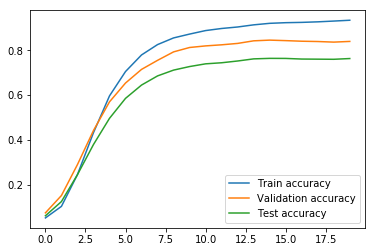

In [12]:
lrs = [1e-5,1e-6,1e-7,1e-8]
models_tfidf = [0]*len(lrs)
train_results_tfidf = [0]*len(lrs)
for i,lr in enumerate(lrs):
    print "Learning rate: " + repr(lr)
    models_tfidf[i] = MLP_20(Vocab_size,20)
    models_tfidf[i] = GlorotInitialize(models_tfidf[i])
    optimizer = torch.optim.SGD(models_tfidf[i].parameters(),lr=lr,momentum=0.9)
    loss_crit = nn.CrossEntropyLoss()
    train_results_tfidf[i] = train(models_tfidf[i],20,train_loader_tfidf,optimizer,val_loader_tfidf,test_loader_tfidf)
    (bestNetwork, epoch_loss, train_accuracy, val_accuracy, test_accuracy) = train_results_tfidf[i]
    
    plt.plot(train_accuracy, label='Train accuracy')
    plt.plot(val_accuracy, label='Validation accuracy')
    plt.plot(test_accuracy, label='Test accuracy')
    plt.legend()
    plt.show()

In [6]:
#Standardization preprocessing


In [6]:
data = np.loadtxt('./data/20news-bydate/matlab/train.data')
labels = np.loadtxt('./data/20news-bydate/matlab/train.label')
labels -= 1

test_data = np.loadtxt('./data/20news-bydate/matlab/test.data')
test_labels = np.loadtxt('./data/20news-bydate/matlab/test.label')
test_labels -= 1

data = restructure_data(data)
data = standardize_data(data)
Vocab_size = data.shape[1]
test_data = restructure_data(test_data)[:,:Vocab_size]
test_data = standardize_data(test_data)

train_loader_std, val_loader_std, test_loader_std = make_loaders(data,labels,0.8,test_data,test_labels)
del data
del test_data

KeyboardInterrupt: 

Learning rate: 0.0001
Epoch : 1 Loss : 2.402  Train Accuracy: 0.356 Validation Accuracy: 0.726 Test Accuracy: 0.620
Epoch : 2 Loss : 0.257  Train Accuracy: 0.935 Validation Accuracy: 0.800 Test Accuracy: 0.676
Epoch : 3 Loss : 0.179  Train Accuracy: 0.965 Validation Accuracy: 0.817 Test Accuracy: 0.689
Epoch : 4 Loss : 0.210  Train Accuracy: 0.969 Validation Accuracy: 0.841 Test Accuracy: 0.711
Epoch : 5 Loss : 0.526  Train Accuracy: 0.963 Validation Accuracy: 0.839 Test Accuracy: 0.716
Epoch : 6 Loss : 0.572  Train Accuracy: 0.967 Validation Accuracy: 0.832 Test Accuracy: 0.702
Epoch : 7 Loss : 0.986  Train Accuracy: 0.968 Validation Accuracy: 0.818 Test Accuracy: 0.690
Epoch : 8 Loss : 1.752  Train Accuracy: 0.966 Validation Accuracy: 0.823 Test Accuracy: 0.699
Epoch : 9 Loss : 2.973  Train Accuracy: 0.964 Validation Accuracy: 0.816 Test Accuracy: 0.684
Epoch : 10 Loss : 0.705  Train Accuracy: 0.985 Validation Accuracy: 0.833 Test Accuracy: 0.697
Epoch : 11 Loss : 2.505  Train Accura

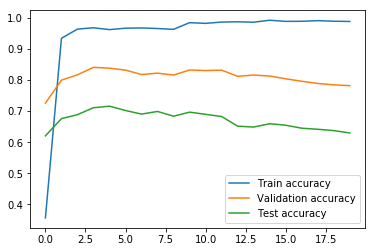

Learning rate: 1e-05
Epoch : 1 Loss : 3.428  Train Accuracy: 0.077 Validation Accuracy: 0.178 Test Accuracy: 0.149
Epoch : 2 Loss : 1.452  Train Accuracy: 0.678 Validation Accuracy: 0.628 Test Accuracy: 0.524
Epoch : 3 Loss : 0.491  Train Accuracy: 0.940 Validation Accuracy: 0.766 Test Accuracy: 0.656
Epoch : 4 Loss : 0.226  Train Accuracy: 0.957 Validation Accuracy: 0.779 Test Accuracy: 0.661
Epoch : 5 Loss : 0.161  Train Accuracy: 0.959 Validation Accuracy: 0.780 Test Accuracy: 0.658
Epoch : 6 Loss : 0.121  Train Accuracy: 0.970 Validation Accuracy: 0.796 Test Accuracy: 0.669
Epoch : 7 Loss : 0.088  Train Accuracy: 0.976 Validation Accuracy: 0.811 Test Accuracy: 0.676
Epoch : 8 Loss : 0.064  Train Accuracy: 0.984 Validation Accuracy: 0.831 Test Accuracy: 0.697
Epoch : 9 Loss : 0.059  Train Accuracy: 0.986 Validation Accuracy: 0.841 Test Accuracy: 0.708
Epoch : 10 Loss : 0.056  Train Accuracy: 0.986 Validation Accuracy: 0.850 Test Accuracy: 0.716
Epoch : 11 Loss : 0.047  Train Accurac

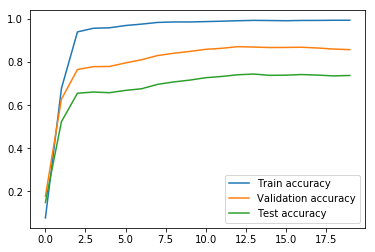

Learning rate: 1e-06
Epoch : 1 Loss : 3.648  Train Accuracy: 0.053 Validation Accuracy: 0.056 Test Accuracy: 0.058
Epoch : 2 Loss : 3.207  Train Accuracy: 0.094 Validation Accuracy: 0.093 Test Accuracy: 0.085
Epoch : 3 Loss : 2.542  Train Accuracy: 0.248 Validation Accuracy: 0.187 Test Accuracy: 0.155
Epoch : 4 Loss : 1.876  Train Accuracy: 0.513 Validation Accuracy: 0.345 Test Accuracy: 0.281
Epoch : 5 Loss : 1.340  Train Accuracy: 0.744 Validation Accuracy: 0.500 Test Accuracy: 0.407
Epoch : 6 Loss : 0.953  Train Accuracy: 0.864 Validation Accuracy: 0.610 Test Accuracy: 0.503
Epoch : 7 Loss : 0.692  Train Accuracy: 0.920 Validation Accuracy: 0.672 Test Accuracy: 0.564
Epoch : 8 Loss : 0.517  Train Accuracy: 0.945 Validation Accuracy: 0.714 Test Accuracy: 0.605
Epoch : 9 Loss : 0.395  Train Accuracy: 0.954 Validation Accuracy: 0.734 Test Accuracy: 0.629
Epoch : 10 Loss : 0.313  Train Accuracy: 0.956 Validation Accuracy: 0.751 Test Accuracy: 0.640
Epoch : 11 Loss : 0.257  Train Accurac

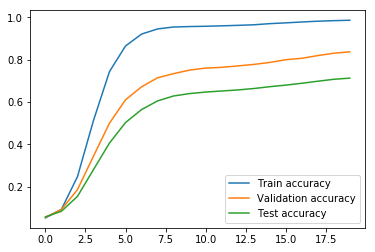

Learning rate: 1e-07
Epoch : 1 Loss : 3.759  Train Accuracy: 0.052 Validation Accuracy: 0.058 Test Accuracy: 0.052
Epoch : 2 Loss : 3.705  Train Accuracy: 0.056 Validation Accuracy: 0.058 Test Accuracy: 0.054
Epoch : 3 Loss : 3.593  Train Accuracy: 0.062 Validation Accuracy: 0.061 Test Accuracy: 0.058
Epoch : 4 Loss : 3.437  Train Accuracy: 0.073 Validation Accuracy: 0.066 Test Accuracy: 0.062
Epoch : 5 Loss : 3.242  Train Accuracy: 0.090 Validation Accuracy: 0.070 Test Accuracy: 0.070
Epoch : 6 Loss : 3.028  Train Accuracy: 0.122 Validation Accuracy: 0.083 Test Accuracy: 0.081
Epoch : 7 Loss : 2.804  Train Accuracy: 0.167 Validation Accuracy: 0.104 Test Accuracy: 0.100
Epoch : 8 Loss : 2.571  Train Accuracy: 0.231 Validation Accuracy: 0.134 Test Accuracy: 0.120
Epoch : 9 Loss : 2.340  Train Accuracy: 0.313 Validation Accuracy: 0.157 Test Accuracy: 0.148
Epoch : 10 Loss : 2.115  Train Accuracy: 0.406 Validation Accuracy: 0.195 Test Accuracy: 0.179
Epoch : 11 Loss : 1.901  Train Accurac

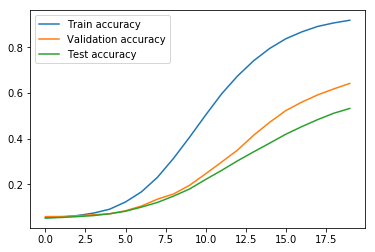

In [13]:
lrs = [1e-4,1e-5,1e-6,1e-7]
models_std = [0]*len(lrs)
train_results_std = [0]*len(lrs)
for i,lr in enumerate(lrs):
    print "Learning rate: " + repr(lr)
    models_std[i] = MLP_20(Vocab_size,20)
    models_std[i] = GlorotInitialize(models_std[i])
    optimizer = torch.optim.SGD(models_std[i].parameters(),lr=lr,momentum=0.9)
    loss_crit = nn.CrossEntropyLoss()
    train_results_std[i] = train(models_std[i],20,train_loader_std,optimizer,val_loader_std,test_loader_std)
    (bestNetwork, epoch_loss, train_accuracy, val_accuracy, test_accuracy) = train_results_std[i]
    
    plt.plot(train_accuracy, label='Train accuracy')
    plt.plot(val_accuracy, label='Validation accuracy')
    plt.plot(test_accuracy, label='Test accuracy')
    plt.legend()
    plt.show()

## Variance in Training

Best results from before:


Using the best performing network for this section. TF-IDF with learning rate 1e-5

In [9]:
def train_5000(model,train_loader,optimizer,loss_func, verbose= True):
    losses = [0]*5000
    batch_number = 0
    model = GlorotInitialize(model)
    for i in range(1000):
        for batch_index, (inputs, targets) in enumerate(train_loader):
            
            x, targets = Variable(inputs.view([-1,model.insize])), Variable(targets)

            logits = model.forward(x)
            loss = loss_func(logits,targets)
            
            loss.backward()
            optimizer.step()
            losses[batch_number] = (loss.data[0])
            if (verbose):
                print "Iteration: " + repr(batch_number + 1) + " Loss: " + repr(loss.data[0])
            batch_number += 1
            if batch_number == 5000:
                plt.plot(losses, label='Train losses')
                plt.legend()
                plt.show()
                return model,losses

In [19]:
data = np.loadtxt('./data/20news-bydate/matlab/train.data')
labels = np.loadtxt('./data/20news-bydate/matlab/train.label')
labels -= 1
data = restructure_data(data)
data = tfidf(data)
Vocab_size = data.shape[1]



In [7]:
train_loader,_= make_loaders(data,labels,1,batch_size=1)

(11269, 53975) (11269,)
(0, 53975) (0,)


Iteration: 1 Loss: 2.9472641944885254
Iteration: 2 Loss: 3.744807481765747
Iteration: 3 Loss: 4.2447075843811035
Iteration: 4 Loss: 16.55099868774414
Iteration: 5 Loss: 7.879836559295654
Iteration: 6 Loss: 101.2024154663086
Iteration: 7 Loss: 498.0543212890625
Iteration: 8 Loss: 6515.521484375
Iteration: 9 Loss: 243.3502655029297
Iteration: 10 Loss: 351.3574523925781
Iteration: 11 Loss: 2054.049072265625
Iteration: 12 Loss: 81.2745361328125
Iteration: 13 Loss: 89.53658294677734
Iteration: 14 Loss: 3.6093783378601074
Iteration: 15 Loss: 3.029707670211792
Iteration: 16 Loss: 3.203315496444702
Iteration: 17 Loss: 14.305985450744629
Iteration: 18 Loss: 3.263479232788086
Iteration: 19 Loss: 2.138319253921509
Iteration: 20 Loss: 20.524566650390625
Iteration: 21 Loss: 3.5107321739196777
Iteration: 22 Loss: 154.22618103027344
Iteration: 23 Loss: 3.588806629180908
Iteration: 24 Loss: 29.866851806640625
Iteration: 25 Loss: 3.628781318664551
Iteration: 26 Loss: 4.928250312805176
Iteration: 27 Los

Iteration: 216 Loss: 0.9372445940971375
Iteration: 217 Loss: 10.299996376037598
Iteration: 218 Loss: 2105.2880859375
Iteration: 219 Loss: 17.24049186706543
Iteration: 220 Loss: 2.148489475250244
Iteration: 221 Loss: 3.786994218826294
Iteration: 222 Loss: 9.34863567352295
Iteration: 223 Loss: 17.981748580932617
Iteration: 224 Loss: 10.102069854736328
Iteration: 225 Loss: 15.25899887084961
Iteration: 226 Loss: 17.98805809020996
Iteration: 227 Loss: 3.832362651824951
Iteration: 228 Loss: 12.805386543273926
Iteration: 229 Loss: 3864.189208984375
Iteration: 230 Loss: 10.451221466064453
Iteration: 231 Loss: 3.874316692352295
Iteration: 232 Loss: 12.809550285339355
Iteration: 233 Loss: 0.443040132522583
Iteration: 234 Loss: 22.711708068847656
Iteration: 235 Loss: 2.3020803928375244
Iteration: 236 Loss: 9.549423217773438
Iteration: 237 Loss: 22.87041664123535
Iteration: 238 Loss: 11.218276023864746
Iteration: 239 Loss: 1.131445288658142
Iteration: 240 Loss: 919726.875
Iteration: 241 Loss: 6.69

Iteration: 432 Loss: 26.751325607299805
Iteration: 433 Loss: 33.91695022583008
Iteration: 434 Loss: 12.089083671569824
Iteration: 435 Loss: 13.557119369506836
Iteration: 436 Loss: 48.19114685058594
Iteration: 437 Loss: 1.3127081394195557
Iteration: 438 Loss: 9.263233184814453
Iteration: 439 Loss: 16.217153549194336
Iteration: 440 Loss: 15.749503135681152
Iteration: 441 Loss: 7.9369120597839355
Iteration: 442 Loss: 14.641838073730469
Iteration: 443 Loss: 1.7527625560760498
Iteration: 444 Loss: 1.709904670715332
Iteration: 445 Loss: 12.277706146240234
Iteration: 446 Loss: 2.4635682106018066
Iteration: 447 Loss: 3.0764682292938232
Iteration: 448 Loss: 1.1237086057662964
Iteration: 449 Loss: 12.213019371032715
Iteration: 450 Loss: 12.969202041625977
Iteration: 451 Loss: 4.66739559173584
Iteration: 452 Loss: 0.4797089695930481
Iteration: 453 Loss: 12.962920188903809
Iteration: 454 Loss: 8.550278663635254
Iteration: 455 Loss: 49.734764099121094
Iteration: 456 Loss: 7.172919750213623
Iteratio

Iteration: 647 Loss: 1.0292249917984009
Iteration: 648 Loss: 19.066144943237305
Iteration: 649 Loss: 10.164889335632324
Iteration: 650 Loss: 33.664310455322266
Iteration: 651 Loss: 30.39613914489746
Iteration: 652 Loss: 2.197293281555176
Iteration: 653 Loss: 2.051403045654297
Iteration: 654 Loss: 29.53936767578125
Iteration: 655 Loss: 71.67910766601562
Iteration: 656 Loss: 7.386125087738037
Iteration: 657 Loss: 14.843711853027344
Iteration: 658 Loss: 16.82606315612793
Iteration: 659 Loss: 5.72268009185791
Iteration: 660 Loss: 16.57352638244629
Iteration: 661 Loss: 12.141838073730469
Iteration: 662 Loss: 3.8589251041412354
Iteration: 663 Loss: 16.06787872314453
Iteration: 664 Loss: 15.202739715576172
Iteration: 665 Loss: 24.466495513916016
Iteration: 666 Loss: 15.988883018493652
Iteration: 667 Loss: 4.3720598220825195
Iteration: 668 Loss: 3.102846145629883
Iteration: 669 Loss: 16.806711196899414
Iteration: 670 Loss: 0.9222579002380371
Iteration: 671 Loss: 17.39996337890625
Iteration: 67

Iteration: 855 Loss: 4.246091842651367
Iteration: 856 Loss: 62.757755279541016
Iteration: 857 Loss: 41.90727996826172
Iteration: 858 Loss: 20.427072525024414
Iteration: 859 Loss: 19.72481346130371
Iteration: 860 Loss: 42.15958786010742
Iteration: 861 Loss: 63.44353103637695
Iteration: 862 Loss: 0.05519672483205795
Iteration: 863 Loss: 5.677388668060303
Iteration: 864 Loss: 5.573096752166748
Iteration: 865 Loss: 3.3728585243225098
Iteration: 866 Loss: 3.0266709327697754
Iteration: 867 Loss: 11.263904571533203
Iteration: 868 Loss: 34.89609909057617
Iteration: 869 Loss: 15.012105941772461
Iteration: 870 Loss: 4.325912952423096
Iteration: 871 Loss: 61.253135681152344
Iteration: 872 Loss: 39.049591064453125
Iteration: 873 Loss: 12.819079399108887
Iteration: 874 Loss: 84.79985046386719
Iteration: 875 Loss: 57.933197021484375
Iteration: 876 Loss: 52.16298294067383
Iteration: 877 Loss: 3.115077495574951
Iteration: 878 Loss: 33.991241455078125
Iteration: 879 Loss: 56.59675216674805
Iteration: 8

Iteration: 1068 Loss: 2.9123895168304443
Iteration: 1069 Loss: 64.56234741210938
Iteration: 1070 Loss: 5.244788646697998
Iteration: 1071 Loss: 39.170082092285156
Iteration: 1072 Loss: 79.87248229980469
Iteration: 1073 Loss: 16.721405029296875
Iteration: 1074 Loss: 32.92090606689453
Iteration: 1075 Loss: 80.005126953125
Iteration: 1076 Loss: 26.739831924438477
Iteration: 1077 Loss: 76.4660415649414
Iteration: 1078 Loss: 28.613697052001953
Iteration: 1079 Loss: 78.15895080566406
Iteration: 1080 Loss: 20.429426193237305
Iteration: 1081 Loss: 58.193607330322266
Iteration: 1082 Loss: 21.706815719604492
Iteration: 1083 Loss: 64.16191864013672
Iteration: 1084 Loss: 5.81760311126709
Iteration: 1085 Loss: 78.07109832763672
Iteration: 1086 Loss: 64.78063201904297
Iteration: 1087 Loss: 23.911754608154297
Iteration: 1088 Loss: 33.83347702026367
Iteration: 1089 Loss: 68.10636901855469
Iteration: 1090 Loss: 31.814050674438477
Iteration: 1091 Loss: 1.6597164869308472
Iteration: 1092 Loss: 30.41711997

Iteration: 1286 Loss: 49.92631530761719
Iteration: 1287 Loss: 5.539880752563477
Iteration: 1288 Loss: 56.03860855102539
Iteration: 1289 Loss: 0.5073938369750977
Iteration: 1290 Loss: 5.051299571990967
Iteration: 1291 Loss: 11.711373329162598
Iteration: 1292 Loss: 41.74283981323242
Iteration: 1293 Loss: 15.040962219238281
Iteration: 1294 Loss: 85.06774139404297
Iteration: 1295 Loss: 6.856585502624512
Iteration: 1296 Loss: 7.631613731384277
Iteration: 1297 Loss: 13.02652359008789
Iteration: 1298 Loss: 7.606887340545654
Iteration: 1299 Loss: 25.385971069335938
Iteration: 1300 Loss: 1430605.5
Iteration: 1301 Loss: 58.46598434448242
Iteration: 1302 Loss: 0.6764249801635742
Iteration: 1303 Loss: 58.83345413208008
Iteration: 1304 Loss: 107.32303619384766
Iteration: 1305 Loss: 127.23748779296875
Iteration: 1306 Loss: 25.765216827392578
Iteration: 1307 Loss: 13.743946075439453
Iteration: 1308 Loss: 100.7406234741211
Iteration: 1309 Loss: 9.897921562194824
Iteration: 1310 Loss: 102.4327163696289

Iteration: 1491 Loss: 147.4611358642578
Iteration: 1492 Loss: 75.36094665527344
Iteration: 1493 Loss: 50.13888931274414
Iteration: 1494 Loss: 32.61515808105469
Iteration: 1495 Loss: 29.83380126953125
Iteration: 1496 Loss: 0.2337663322687149
Iteration: 1497 Loss: 6.422550201416016
Iteration: 1498 Loss: 7.343461513519287
Iteration: 1499 Loss: 270.2900085449219
Iteration: 1500 Loss: 40.175777435302734
Iteration: 1501 Loss: 53.13506317138672
Iteration: 1502 Loss: 53.76197814941406
Iteration: 1503 Loss: 2.248213768005371
Iteration: 1504 Loss: 26.443639755249023
Iteration: 1505 Loss: 40.856056213378906
Iteration: 1506 Loss: 5.836042404174805
Iteration: 1507 Loss: 0.0067689502611756325
Iteration: 1508 Loss: 30.418020248413086
Iteration: 1509 Loss: 40.992156982421875
Iteration: 1510 Loss: 14.053338050842285
Iteration: 1511 Loss: 15.432817459106445
Iteration: 1512 Loss: 22.349044799804688
Iteration: 1513 Loss: 83.80916595458984
Iteration: 1514 Loss: 145.85174560546875
Iteration: 1515 Loss: 10.1

Iteration: 1696 Loss: 30.21646499633789
Iteration: 1697 Loss: 23.2811222076416
Iteration: 1698 Loss: 117.34996795654297
Iteration: 1699 Loss: 16.000579833984375
Iteration: 1700 Loss: 0.5340099334716797
Iteration: 1701 Loss: 22.0382137298584
Iteration: 1702 Loss: 116.76793670654297
Iteration: 1703 Loss: 36.63909912109375
Iteration: 1704 Loss: 37.607845306396484
Iteration: 1705 Loss: 5.688403129577637
Iteration: 1706 Loss: 21.931344985961914
Iteration: 1707 Loss: 24.295942306518555
Iteration: 1708 Loss: 164.2843017578125
Iteration: 1709 Loss: 119.58720397949219
Iteration: 1710 Loss: 119.5868911743164
Iteration: 1711 Loss: 14.668242454528809
Iteration: 1712 Loss: 96.23822784423828
Iteration: 1713 Loss: 15.398336410522461
Iteration: 1714 Loss: 42.32207107543945
Iteration: 1715 Loss: 14.963610649108887
Iteration: 1716 Loss: 17.524595260620117
Iteration: 1717 Loss: 27.95088768005371
Iteration: 1718 Loss: 14.169522285461426
Iteration: 1719 Loss: 40.7209358215332
Iteration: 1720 Loss: 27.76996

Iteration: 1902 Loss: 24.857789993286133
Iteration: 1903 Loss: 41.61058807373047
Iteration: 1904 Loss: 72.11601257324219
Iteration: 1905 Loss: 244.95176696777344
Iteration: 1906 Loss: 28.997114181518555
Iteration: 1907 Loss: 41.50612258911133
Iteration: 1908 Loss: 1.659067153930664
Iteration: 1909 Loss: 0.876365065574646
Iteration: 1910 Loss: 68.46858215332031
Iteration: 1911 Loss: 27.83466339111328
Iteration: 1912 Loss: 31.318471908569336
Iteration: 1913 Loss: 28.37166976928711
Iteration: 1914 Loss: 77.25968933105469
Iteration: 1915 Loss: 250.4493408203125
Iteration: 1916 Loss: 68.28398895263672
Iteration: 1917 Loss: 8.700946807861328
Iteration: 1918 Loss: 75.8052978515625
Iteration: 1919 Loss: 8.414872169494629
Iteration: 1920 Loss: 2.8119702339172363
Iteration: 1921 Loss: 34.87405014038086
Iteration: 1922 Loss: 30.738203048706055
Iteration: 1923 Loss: 30.908443450927734
Iteration: 1924 Loss: 1.5309423208236694
Iteration: 1925 Loss: 53.101810455322266
Iteration: 1926 Loss: 52.4121208

Iteration: 2111 Loss: 8.423645973205566
Iteration: 2112 Loss: 2.271442413330078
Iteration: 2113 Loss: 9.183079719543457
Iteration: 2114 Loss: 46.50966262817383
Iteration: 2115 Loss: 272.1440124511719
Iteration: 2116 Loss: 24.485994338989258
Iteration: 2117 Loss: 24.858659744262695
Iteration: 2118 Loss: 34.20120620727539
Iteration: 2119 Loss: 67.90179443359375
Iteration: 2120 Loss: 14.496585845947266
Iteration: 2121 Loss: 67.55705261230469
Iteration: 2122 Loss: 43.720306396484375
Iteration: 2123 Loss: 36.93412399291992
Iteration: 2124 Loss: 42.13660430908203
Iteration: 2125 Loss: 157.2663116455078
Iteration: 2126 Loss: 6.836714267730713
Iteration: 2127 Loss: 37.160133361816406
Iteration: 2128 Loss: 35.32880401611328
Iteration: 2129 Loss: 36.55613708496094
Iteration: 2130 Loss: 60.785579681396484
Iteration: 2131 Loss: 34.48102569580078
Iteration: 2132 Loss: 3.63154935836792
Iteration: 2133 Loss: 18.42032814025879
Iteration: 2134 Loss: 33.207157135009766
Iteration: 2135 Loss: 56.112915039

Iteration: 2322 Loss: 46.67888259887695
Iteration: 2323 Loss: 27.943967819213867
Iteration: 2324 Loss: 65.78950500488281
Iteration: 2325 Loss: 5.789748668670654
Iteration: 2326 Loss: 84.6889877319336
Iteration: 2327 Loss: 15.087693214416504
Iteration: 2328 Loss: 30.66536521911621
Iteration: 2329 Loss: 13.143156051635742
Iteration: 2330 Loss: 69.70401763916016
Iteration: 2331 Loss: 29.653564453125
Iteration: 2332 Loss: 128.57656860351562
Iteration: 2333 Loss: 72.82734680175781
Iteration: 2334 Loss: 84.85945892333984
Iteration: 2335 Loss: 19.37419319152832
Iteration: 2336 Loss: 26.676673889160156
Iteration: 2337 Loss: 158.2202606201172
Iteration: 2338 Loss: 87.56639862060547
Iteration: 2339 Loss: 76.15449523925781
Iteration: 2340 Loss: 23.71088981628418
Iteration: 2341 Loss: 23.36271858215332
Iteration: 2342 Loss: 135.83383178710938
Iteration: 2343 Loss: 47.34855651855469
Iteration: 2344 Loss: 157.053955078125
Iteration: 2345 Loss: 5.396718978881836
Iteration: 2346 Loss: 26.1250495910644

Iteration: 2534 Loss: 0.001805249834433198
Iteration: 2535 Loss: 47.26681900024414
Iteration: 2536 Loss: 59.74631881713867
Iteration: 2537 Loss: 113.70804595947266
Iteration: 2538 Loss: 7.143270492553711
Iteration: 2539 Loss: 7.034663677215576
Iteration: 2540 Loss: 56.78933334350586
Iteration: 2541 Loss: 0.00552101107314229
Iteration: 2542 Loss: 6.003178119659424
Iteration: 2543 Loss: 75.150146484375
Iteration: 2544 Loss: 26.866615295410156
Iteration: 2545 Loss: 44.518226623535156
Iteration: 2546 Loss: 124.2372055053711
Iteration: 2547 Loss: 5.041358470916748
Iteration: 2548 Loss: 51.93621826171875
Iteration: 2549 Loss: 210.14959716796875
Iteration: 2550 Loss: 190.08847045898438
Iteration: 2551 Loss: 62.2257194519043
Iteration: 2552 Loss: 177.8945770263672
Iteration: 2553 Loss: 107.94754028320312
Iteration: 2554 Loss: 212.58604431152344
Iteration: 2555 Loss: 124.86589050292969
Iteration: 2556 Loss: 112.47284698486328
Iteration: 2557 Loss: 188.13316345214844
Iteration: 2558 Loss: 32.447

Iteration: 2742 Loss: 23.90781593322754
Iteration: 2743 Loss: 119.57015228271484
Iteration: 2744 Loss: 30.311946868896484
Iteration: 2745 Loss: 36.706336975097656
Iteration: 2746 Loss: 2.1847190856933594
Iteration: 2747 Loss: 124.79236602783203
Iteration: 2748 Loss: 7.321864604949951
Iteration: 2749 Loss: 35.48567199707031
Iteration: 2750 Loss: 0.04217708855867386
Iteration: 2751 Loss: 123.95576477050781
Iteration: 2752 Loss: 204.2198028564453
Iteration: 2753 Loss: 124.64473724365234
Iteration: 2754 Loss: 8.622010231018066
Iteration: 2755 Loss: 125.14360046386719
Iteration: 2756 Loss: 28.725914001464844
Iteration: 2757 Loss: 151.41029357910156
Iteration: 2758 Loss: 34.37518310546875
Iteration: 2759 Loss: 46.24795150756836
Iteration: 2760 Loss: 42.120391845703125
Iteration: 2761 Loss: 0.9683497548103333
Iteration: 2762 Loss: 115.45650482177734
Iteration: 2763 Loss: 42.896728515625
Iteration: 2764 Loss: 49.910945892333984
Iteration: 2765 Loss: 114.463623046875
Iteration: 2766 Loss: 43.69

Iteration: 2963 Loss: 346.749267578125
Iteration: 2964 Loss: 142.906005859375
Iteration: 2965 Loss: 33.05729293823242
Iteration: 2966 Loss: 41.698543548583984
Iteration: 2967 Loss: 30.984819412231445
Iteration: 2968 Loss: 23.786155700683594
Iteration: 2969 Loss: 326.5468444824219
Iteration: 2970 Loss: 42.49699401855469
Iteration: 2971 Loss: 22.307538986206055
Iteration: 2972 Loss: 26.740901947021484
Iteration: 2973 Loss: 43.16852951049805
Iteration: 2974 Loss: 34.91072082519531
Iteration: 2975 Loss: 210.37374877929688
Iteration: 2976 Loss: 36.56855392456055
Iteration: 2977 Loss: 132.66360473632812
Iteration: 2978 Loss: 19.979948043823242
Iteration: 2979 Loss: 0.010635387152433395
Iteration: 2980 Loss: 5.004297733306885
Iteration: 2981 Loss: 35.86174774169922
Iteration: 2982 Loss: 17.608230590820312
Iteration: 2983 Loss: 34.02530288696289
Iteration: 2984 Loss: 164.93955993652344
Iteration: 2985 Loss: 343.8622741699219
Iteration: 2986 Loss: 324.2061767578125
Iteration: 2987 Loss: 0.00616

Iteration: 3171 Loss: 22.72586441040039
Iteration: 3172 Loss: 8.393811225891113
Iteration: 3173 Loss: 24.811771392822266
Iteration: 3174 Loss: 8.578660011291504
Iteration: 3175 Loss: 26.27776527404785
Iteration: 3176 Loss: 264.58709716796875
Iteration: 3177 Loss: 63.66069793701172
Iteration: 3178 Loss: 201.67530822753906
Iteration: 3179 Loss: 298.1304016113281
Iteration: 3180 Loss: 148.02040100097656
Iteration: 3181 Loss: 74.64981842041016
Iteration: 3182 Loss: 11.46566104888916
Iteration: 3183 Loss: 6.787439823150635
Iteration: 3184 Loss: 70.92330932617188
Iteration: 3185 Loss: 11.125594139099121
Iteration: 3186 Loss: 41.68314743041992
Iteration: 3187 Loss: 27.79061508178711
Iteration: 3188 Loss: 42.557098388671875
Iteration: 3189 Loss: 29.607059478759766
Iteration: 3190 Loss: 326.7502746582031
Iteration: 3191 Loss: 38.270057678222656
Iteration: 3192 Loss: 201.38429260253906
Iteration: 3193 Loss: 31.808828353881836
Iteration: 3194 Loss: 4.689130783081055
Iteration: 3195 Loss: 0.058048

Iteration: 3379 Loss: 239.76116943359375
Iteration: 3380 Loss: 119.33196258544922
Iteration: 3381 Loss: 4.933777332305908
Iteration: 3382 Loss: 126.50875091552734
Iteration: 3383 Loss: 18.369647979736328
Iteration: 3384 Loss: 59.81664276123047
Iteration: 3385 Loss: 4.782774448394775
Iteration: 3386 Loss: 103.39834594726562
Iteration: 3387 Loss: 104.41825103759766
Iteration: 3388 Loss: 180.83872985839844
Iteration: 3389 Loss: 181.8031463623047
Iteration: 3390 Loss: 390.0061950683594
Iteration: 3391 Loss: 69.10477447509766
Iteration: 3392 Loss: 32.20327377319336
Iteration: 3393 Loss: 186.23748779296875
Iteration: 3394 Loss: 17.616405487060547
Iteration: 3395 Loss: 134.54896545410156
Iteration: 3396 Loss: 18.363109588623047
Iteration: 3397 Loss: 151.8991241455078
Iteration: 3398 Loss: 320.3448486328125
Iteration: 3399 Loss: 155.37059020996094
Iteration: 3400 Loss: 402.88323974609375
Iteration: 3401 Loss: 30.893890380859375
Iteration: 3402 Loss: 105.04602813720703
Iteration: 3403 Loss: 53.

Iteration: 3583 Loss: 46.699317932128906
Iteration: 3584 Loss: 124.43408203125
Iteration: 3585 Loss: 123.7216567993164
Iteration: 3586 Loss: 39.44950866699219
Iteration: 3587 Loss: 240.4012908935547
Iteration: 3588 Loss: 99.85466766357422
Iteration: 3589 Loss: 293.05889892578125
Iteration: 3590 Loss: 61.82933807373047
Iteration: 3591 Loss: 291.2549133300781
Iteration: 3592 Loss: 0.07777844369411469
Iteration: 3593 Loss: 11.063064575195312
Iteration: 3594 Loss: 288.5374450683594
Iteration: 3595 Loss: 112.8331527709961
Iteration: 3596 Loss: 112.373779296875
Iteration: 3597 Loss: 378.3114929199219
Iteration: 3598 Loss: 288.0108642578125
Iteration: 3599 Loss: 379.6200866699219
Iteration: 3600 Loss: 69.54608917236328
Iteration: 3601 Loss: 0.0460493303835392
Iteration: 3602 Loss: 73.90801239013672
Iteration: 3603 Loss: 82.72493743896484
Iteration: 3604 Loss: 96.31885528564453
Iteration: 3605 Loss: 0.0009522329200990498
Iteration: 3606 Loss: 42.24336242675781
Iteration: 3607 Loss: 41.28284835

Iteration: 3797 Loss: 264.6572570800781
Iteration: 3798 Loss: 9.904376983642578
Iteration: 3799 Loss: 25.21285629272461
Iteration: 3800 Loss: 296.80859375
Iteration: 3801 Loss: 194.81483459472656
Iteration: 3802 Loss: 212.72547912597656
Iteration: 3803 Loss: 24.316198348999023
Iteration: 3804 Loss: 215.3609161376953
Iteration: 3805 Loss: 179.41470336914062
Iteration: 3806 Loss: 62.54439926147461
Iteration: 3807 Loss: 292.8546142578125
Iteration: 3808 Loss: 224.57577514648438
Iteration: 3809 Loss: 81.72319793701172
Iteration: 3810 Loss: 24.65930938720703
Iteration: 3811 Loss: 118.6816177368164
Iteration: 3812 Loss: 56.993408203125
Iteration: 3813 Loss: 193.3955841064453
Iteration: 3814 Loss: 9.391075134277344
Iteration: 3815 Loss: 53.724308013916016
Iteration: 3816 Loss: 222.53411865234375
Iteration: 3817 Loss: 61.87664031982422
Iteration: 3818 Loss: 135.72042846679688
Iteration: 3819 Loss: 215.26425170898438
Iteration: 3820 Loss: 98.24752044677734
Iteration: 3821 Loss: 214.354309082031

Iteration: 4016 Loss: 0.0001733866083668545
Iteration: 4017 Loss: 319.19317626953125
Iteration: 4018 Loss: 200.00506591796875
Iteration: 4019 Loss: 87.18342590332031
Iteration: 4020 Loss: 677.089599609375
Iteration: 4021 Loss: 159.56094360351562
Iteration: 4022 Loss: 14.656347274780273
Iteration: 4023 Loss: 61.06380844116211
Iteration: 4024 Loss: 18.658000946044922
Iteration: 4025 Loss: 19.25338363647461
Iteration: 4026 Loss: 5.516339297173545e-05
Iteration: 4027 Loss: 174.6630096435547
Iteration: 4028 Loss: 23.55327033996582
Iteration: 4029 Loss: 688.2093505859375
Iteration: 4030 Loss: 25.76153564453125
Iteration: 4031 Loss: 314.0416259765625
Iteration: 4032 Loss: 104.02870178222656
Iteration: 4033 Loss: 64.58604431152344
Iteration: 4034 Loss: 225.1227264404297
Iteration: 4035 Loss: 255.9489288330078
Iteration: 4036 Loss: 2.7703208616003394e-09
Iteration: 4037 Loss: 157.71974182128906
Iteration: 4038 Loss: 229.19081115722656
Iteration: 4039 Loss: 693.7840576171875
Iteration: 4040 Loss

Iteration: 4222 Loss: 232.3015899658203
Iteration: 4223 Loss: 174.6548309326172
Iteration: 4224 Loss: 49.25694274902344
Iteration: 4225 Loss: 82.42279052734375
Iteration: 4226 Loss: 64.41377258300781
Iteration: 4227 Loss: 85.67349243164062
Iteration: 4228 Loss: 1.878674993349705e-11
Iteration: 4229 Loss: 205.46945190429688
Iteration: 4230 Loss: 311.9550476074219
Iteration: 4231 Loss: 207.51612854003906
Iteration: 4232 Loss: 230.7169647216797
Iteration: 4233 Loss: 510.635009765625
Iteration: 4234 Loss: 23.542694091796875
Iteration: 4235 Loss: 510.53668212890625
Iteration: 4236 Loss: 22.257537841796875
Iteration: 4237 Loss: 602.4252319335938
Iteration: 4238 Loss: 97.02731323242188
Iteration: 4239 Loss: 599.8931884765625
Iteration: 4240 Loss: 70.48843383789062
Iteration: 4241 Loss: 97.98836517333984
Iteration: 4242 Loss: 15.70208740234375
Iteration: 4243 Loss: 505.82318115234375
Iteration: 4244 Loss: 174.07972717285156
Iteration: 4245 Loss: 147.9261016845703
Iteration: 4246 Loss: 502.3007

Iteration: 4426 Loss: 177.34243774414062
Iteration: 4427 Loss: 201.5370635986328
Iteration: 4428 Loss: 405.5175476074219
Iteration: 4429 Loss: 125.71015167236328
Iteration: 4430 Loss: 181.09840393066406
Iteration: 4431 Loss: 304.74798583984375
Iteration: 4432 Loss: 45.09304428100586
Iteration: 4433 Loss: 14.389364242553711
Iteration: 4434 Loss: 118.15814971923828
Iteration: 4435 Loss: 164.31463623046875
Iteration: 4436 Loss: 0.6792033314704895
Iteration: 4437 Loss: 194.3165740966797
Iteration: 4438 Loss: 84.7718505859375
Iteration: 4439 Loss: 58.60301971435547
Iteration: 4440 Loss: 160.87950134277344
Iteration: 4441 Loss: 4.22292423248291
Iteration: 4442 Loss: 245.53094482421875
Iteration: 4443 Loss: 0.00801613088697195
Iteration: 4444 Loss: 5.913544654846191
Iteration: 4445 Loss: 383.8588562011719
Iteration: 4446 Loss: 251.65847778320312
Iteration: 4447 Loss: 155.77171325683594
Iteration: 4448 Loss: 202.28656005859375
Iteration: 4449 Loss: 154.5383758544922
Iteration: 4450 Loss: 0.000

Iteration: 4643 Loss: 92.54452514648438
Iteration: 4644 Loss: 114.57659912109375
Iteration: 4645 Loss: 185.29283142089844
Iteration: 4646 Loss: 124.01344299316406
Iteration: 4647 Loss: 111.06475067138672
Iteration: 4648 Loss: 109.02629089355469
Iteration: 4649 Loss: 33.46356201171875
Iteration: 4650 Loss: 108.04682922363281
Iteration: 4651 Loss: 109.49858093261719
Iteration: 4652 Loss: 250.94699096679688
Iteration: 4653 Loss: 249.88992309570312
Iteration: 4654 Loss: 188.9274139404297
Iteration: 4655 Loss: 95.90670776367188
Iteration: 4656 Loss: 196.58016967773438
Iteration: 4657 Loss: 85.82025909423828
Iteration: 4658 Loss: 370.04083251953125
Iteration: 4659 Loss: 80.51481628417969
Iteration: 4660 Loss: 76.19493103027344
Iteration: 4661 Loss: 2.1373125491663814e-11
Iteration: 4662 Loss: 23.332168579101562
Iteration: 4663 Loss: 187.65399169921875
Iteration: 4664 Loss: 175.721435546875
Iteration: 4665 Loss: 448.2347717285156
Iteration: 4666 Loss: 172.79550170898438
Iteration: 4667 Loss: 

Iteration: 4852 Loss: 195.80413818359375
Iteration: 4853 Loss: 140.8517608642578
Iteration: 4854 Loss: 325.77032470703125
Iteration: 4855 Loss: 349.3724060058594
Iteration: 4856 Loss: 373.4772644042969
Iteration: 4857 Loss: 146.25027465820312
Iteration: 4858 Loss: 137.8776092529297
Iteration: 4859 Loss: 223.61163330078125
Iteration: 4860 Loss: 154.99159240722656
Iteration: 4861 Loss: 139.85787963867188
Iteration: 4862 Loss: 348.7417297363281
Iteration: 4863 Loss: 3.8079383557487745e-07
Iteration: 4864 Loss: 198.61843872070312
Iteration: 4865 Loss: 152.2145538330078
Iteration: 4866 Loss: 605.6753540039062
Iteration: 4867 Loss: 313.4419250488281
Iteration: 4868 Loss: 525.750732421875
Iteration: 4869 Loss: 195.96156311035156
Iteration: 4870 Loss: 152.97064208984375
Iteration: 4871 Loss: 0.5500032305717468
Iteration: 4872 Loss: 154.64178466796875
Iteration: 4873 Loss: 607.2920532226562
Iteration: 4874 Loss: 344.3755187988281
Iteration: 4875 Loss: 26.314876556396484
Iteration: 4876 Loss: 15

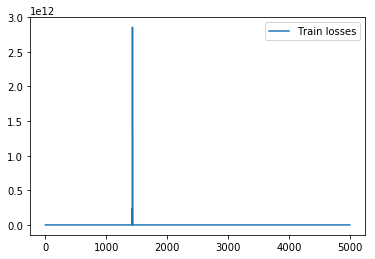

In [15]:
var_model = MLP_20(Vocab_size,20)
optimizer = torch.optim.SGD(var_model.parameters(),lr=0.09)
loss_func = nn.CrossEntropyLoss()
model, losses = train_5000(var_model,train_loader,optimizer,loss_func)

In [20]:
train_loader,_= make_loaders(data,labels,1,batch_size=100)

(11269, 53975) (11269,)
(0, 53975) (0,)


Iteration: 1 Loss: 3.050614833831787
Iteration: 2 Loss: 2.8673555850982666
Iteration: 3 Loss: 2.6124367713928223
Iteration: 4 Loss: 2.4189460277557373
Iteration: 5 Loss: 2.198530673980713
Iteration: 6 Loss: 2.232255458831787
Iteration: 7 Loss: 2.228227376937866
Iteration: 8 Loss: 2.2758595943450928
Iteration: 9 Loss: 1.9762753248214722
Iteration: 10 Loss: 1.7783255577087402
Iteration: 11 Loss: 1.501706600189209
Iteration: 12 Loss: 2.619354486465454
Iteration: 13 Loss: 2.146118402481079
Iteration: 14 Loss: 1.7774995565414429
Iteration: 15 Loss: 2.371474027633667
Iteration: 16 Loss: 2.6062326431274414
Iteration: 17 Loss: 4.415661811828613
Iteration: 18 Loss: 2.3285083770751953
Iteration: 19 Loss: 2.6513102054595947
Iteration: 20 Loss: 4.116663932800293
Iteration: 21 Loss: 2.7429254055023193
Iteration: 22 Loss: 2.997180700302124
Iteration: 23 Loss: 2.9657647609710693
Iteration: 24 Loss: 5.077753067016602
Iteration: 25 Loss: 3.029360771179199
Iteration: 26 Loss: 2.751354932785034
Iteration

Iteration: 230 Loss: 353101.90625
Iteration: 231 Loss: 4342730.5
Iteration: 232 Loss: 21145.671875
Iteration: 233 Loss: 14748.92578125
Iteration: 234 Loss: 246447.921875
Iteration: 235 Loss: 178585680.0
Iteration: 236 Loss: 26659.017578125
Iteration: 237 Loss: 29352.287109375
Iteration: 238 Loss: 4163644416.0
Iteration: 239 Loss: 2632343.5
Iteration: 240 Loss: 5423166.5
Iteration: 241 Loss: 6862367.5
Iteration: 242 Loss: 18086170.0
Iteration: 243 Loss: 315832672.0
Iteration: 244 Loss: 2611715.5
Iteration: 245 Loss: 16982012.0
Iteration: 246 Loss: 269565952.0
Iteration: 247 Loss: 51655060.0
Iteration: 248 Loss: 2106542.5
Iteration: 249 Loss: 1720029.875
Iteration: 250 Loss: 22688616.0
Iteration: 251 Loss: 7644222.0
Iteration: 252 Loss: 2012624.75
Iteration: 253 Loss: 3409048.0
Iteration: 254 Loss: 13981731.0
Iteration: 255 Loss: 78383640.0
Iteration: 256 Loss: 51188060.0
Iteration: 257 Loss: 3654271.75
Iteration: 258 Loss: 25196956.0
Iteration: 259 Loss: 2038467.5
Iteration: 260 Loss: 9

Iteration: 479 Loss: 42273439744.0
Iteration: 480 Loss: 972305536.0
Iteration: 481 Loss: 14101053440.0
Iteration: 482 Loss: 51565512.0
Iteration: 483 Loss: 244942608.0
Iteration: 484 Loss: 229601017856.0
Iteration: 485 Loss: 64361291776.0
Iteration: 486 Loss: 90486857728.0
Iteration: 487 Loss: 4.375347137451172
Iteration: 488 Loss: 47017865216.0
Iteration: 489 Loss: 802109390848.0
Iteration: 490 Loss: 4.948034763336182
Iteration: 491 Loss: 4.762157440185547
Iteration: 492 Loss: 4741372416.0
Iteration: 493 Loss: 3648071401472.0
Iteration: 494 Loss: 33615654912.0
Iteration: 495 Loss: 93028655104.0
Iteration: 496 Loss: 4.9440507888793945
Iteration: 497 Loss: 329685.625
Iteration: 498 Loss: 115869468327936.0
Iteration: 499 Loss: 11297977532416.0
Iteration: 500 Loss: 129830182912.0
Iteration: 501 Loss: 3.7354629039764404
Iteration: 502 Loss: 1475351805952.0
Iteration: 503 Loss: 607384895488.0
Iteration: 504 Loss: 3168897335296.0
Iteration: 505 Loss: 3410134564864.0
Iteration: 506 Loss: 1126

Iteration: 709 Loss: 5.183454990386963
Iteration: 710 Loss: 5.857816219329834
Iteration: 711 Loss: 20157328.0
Iteration: 712 Loss: 5.460860729217529
Iteration: 713 Loss: 5.213415145874023
Iteration: 714 Loss: 3236268.75
Iteration: 715 Loss: 5.139106273651123
Iteration: 716 Loss: 4.686334133148193
Iteration: 717 Loss: 5.526074409484863
Iteration: 718 Loss: 5.125355243682861
Iteration: 719 Loss: 4.895296096801758
Iteration: 720 Loss: 190056.015625
Iteration: 721 Loss: 5.441595077514648
Iteration: 722 Loss: 53377306624.0
Iteration: 723 Loss: 225511833600.0
Iteration: 724 Loss: 5.817744731903076
Iteration: 725 Loss: 1098384128.0
Iteration: 726 Loss: 5.268637657165527
Iteration: 727 Loss: 5.5255866050720215
Iteration: 728 Loss: 5.262714385986328
Iteration: 729 Loss: 545123264.0
Iteration: 730 Loss: 4204417515520.0
Iteration: 731 Loss: 4.951230049133301
Iteration: 732 Loss: 34894104.0
Iteration: 733 Loss: 4.768355369567871
Iteration: 734 Loss: 5.429043769836426
Iteration: 735 Loss: 241742592

Iteration: 930 Loss: 6.607107162475586
Iteration: 931 Loss: 48246952.0
Iteration: 932 Loss: 5.202938079833984
Iteration: 933 Loss: 6.077844619750977
Iteration: 934 Loss: 5.3646159172058105
Iteration: 935 Loss: 6.730100154876709
Iteration: 936 Loss: 5.3417205810546875
Iteration: 937 Loss: 470943.3125
Iteration: 938 Loss: 102961.8515625
Iteration: 939 Loss: 5.334930419921875
Iteration: 940 Loss: 6.207953453063965
Iteration: 941 Loss: 5350586580992.0
Iteration: 942 Loss: 4813853.0
Iteration: 943 Loss: 5.231809139251709
Iteration: 944 Loss: 5.412165641784668
Iteration: 945 Loss: 5.482603549957275
Iteration: 946 Loss: 5.494256973266602
Iteration: 947 Loss: 4.689843654632568
Iteration: 948 Loss: 5.3247222900390625
Iteration: 949 Loss: 29335278.0
Iteration: 950 Loss: 5.476370334625244
Iteration: 951 Loss: 424991.75
Iteration: 952 Loss: 4.948311805725098
Iteration: 953 Loss: 5.424138069152832
Iteration: 954 Loss: 1050802.75
Iteration: 955 Loss: 78169968.0
Iteration: 956 Loss: 6.44400691986084


Iteration: 1142 Loss: 6.491147518157959
Iteration: 1143 Loss: 6.006158351898193
Iteration: 1144 Loss: 5.609157085418701
Iteration: 1145 Loss: 6.153022289276123
Iteration: 1146 Loss: 5.502964973449707
Iteration: 1147 Loss: 5.387925624847412
Iteration: 1148 Loss: 5.912487983703613
Iteration: 1149 Loss: 5.511991500854492
Iteration: 1150 Loss: 5.498105525970459
Iteration: 1151 Loss: 5.484014511108398
Iteration: 1152 Loss: 5.750063896179199
Iteration: 1153 Loss: 5.316750526428223
Iteration: 1154 Loss: 5.203456878662109
Iteration: 1155 Loss: 5.836695671081543
Iteration: 1156 Loss: 5.916325569152832
Iteration: 1157 Loss: 5.927592754364014
Iteration: 1158 Loss: 6.161313056945801
Iteration: 1159 Loss: 5.929278373718262
Iteration: 1160 Loss: 6.281425952911377
Iteration: 1161 Loss: 5.321707248687744
Iteration: 1162 Loss: 5.158982753753662
Iteration: 1163 Loss: 6.135098457336426
Iteration: 1164 Loss: 6.185610771179199
Iteration: 1165 Loss: 5.310972213745117
Iteration: 1166 Loss: 6.059247016906738


Iteration: 1348 Loss: 5.182268142700195
Iteration: 1349 Loss: 5.530651092529297
Iteration: 1350 Loss: 5.5102763175964355
Iteration: 1351 Loss: 5.187762260437012
Iteration: 1352 Loss: 5.590031623840332
Iteration: 1353 Loss: 5.60964822769165
Iteration: 1354 Loss: 5.300298690795898
Iteration: 1355 Loss: 5.362379550933838
Iteration: 1356 Loss: 4.905162334442139
Iteration: 1357 Loss: 5.421753406524658
Iteration: 1358 Loss: 5.218798637390137
Iteration: 1359 Loss: 5.948672294616699
Iteration: 1360 Loss: 5.824595928192139
Iteration: 1361 Loss: 5.4391279220581055
Iteration: 1362 Loss: 5.490448474884033
Iteration: 1363 Loss: 5.450842380523682
Iteration: 1364 Loss: 5.075930118560791
Iteration: 1365 Loss: 5.110870838165283
Iteration: 1366 Loss: 5.608138561248779
Iteration: 1367 Loss: 5.490410804748535
Iteration: 1368 Loss: 6.084147930145264
Iteration: 1369 Loss: 5.364965438842773
Iteration: 1370 Loss: 4.971819877624512
Iteration: 1371 Loss: 5.602646350860596
Iteration: 1372 Loss: 6.755087852478027

Iteration: 1558 Loss: 5.153212070465088
Iteration: 1559 Loss: 5.875828266143799
Iteration: 1560 Loss: 5.213953018188477
Iteration: 1561 Loss: 6.317483425140381
Iteration: 1562 Loss: 5.67338752746582
Iteration: 1563 Loss: 5.8390374183654785
Iteration: 1564 Loss: 2408715.0
Iteration: 1565 Loss: 6.143776893615723
Iteration: 1566 Loss: 4.990043640136719
Iteration: 1567 Loss: 5.7957587242126465
Iteration: 1568 Loss: 6.279228687286377
Iteration: 1569 Loss: 6.501957416534424
Iteration: 1570 Loss: 6.255338668823242
Iteration: 1571 Loss: 5.6897735595703125
Iteration: 1572 Loss: 5.907864570617676
Iteration: 1573 Loss: 5.9239702224731445
Iteration: 1574 Loss: 5.99494743347168
Iteration: 1575 Loss: 6.092836856842041
Iteration: 1576 Loss: 5.876208305358887
Iteration: 1577 Loss: 6.332607269287109
Iteration: 1578 Loss: 6.063897132873535
Iteration: 1579 Loss: 6.156560897827148
Iteration: 1580 Loss: 5.507848739624023
Iteration: 1581 Loss: 6.396432876586914
Iteration: 1582 Loss: 6.330561637878418
Iterat

Iteration: 1770 Loss: 5.517261505126953
Iteration: 1771 Loss: 5.313594341278076
Iteration: 1772 Loss: 5.4381842613220215
Iteration: 1773 Loss: 5.335641860961914
Iteration: 1774 Loss: 6.544946670532227
Iteration: 1775 Loss: 5.6340155601501465
Iteration: 1776 Loss: 5.443350315093994
Iteration: 1777 Loss: 5.898837089538574
Iteration: 1778 Loss: 5.982528209686279
Iteration: 1779 Loss: 6.383264541625977
Iteration: 1780 Loss: 5.41818904876709
Iteration: 1781 Loss: 5.380176544189453
Iteration: 1782 Loss: 5.694208145141602
Iteration: 1783 Loss: 5.715044021606445
Iteration: 1784 Loss: 6.122425079345703
Iteration: 1785 Loss: 5.770383834838867
Iteration: 1786 Loss: 5.690955638885498
Iteration: 1787 Loss: 5.689727306365967
Iteration: 1788 Loss: 6.510469913482666
Iteration: 1789 Loss: 6.125483989715576
Iteration: 1790 Loss: 6.043128490447998
Iteration: 1791 Loss: 5.848433971405029
Iteration: 1792 Loss: 6.550231456756592
Iteration: 1793 Loss: 6.373780727386475
Iteration: 1794 Loss: 5.951252460479736

Iteration: 1980 Loss: 5.842388153076172
Iteration: 1981 Loss: 5.551591873168945
Iteration: 1982 Loss: 4.975182056427002
Iteration: 1983 Loss: 5.443758487701416
Iteration: 1984 Loss: 4.713922500610352
Iteration: 1985 Loss: 5.969414710998535
Iteration: 1986 Loss: 5.053336143493652
Iteration: 1987 Loss: 5.317929744720459
Iteration: 1988 Loss: 5.479101181030273
Iteration: 1989 Loss: 5.956388473510742
Iteration: 1990 Loss: 5.391786098480225
Iteration: 1991 Loss: 5.511940956115723
Iteration: 1992 Loss: 5.534830093383789
Iteration: 1993 Loss: 5.317612171173096
Iteration: 1994 Loss: 5.056869983673096
Iteration: 1995 Loss: 5.666623592376709
Iteration: 1996 Loss: 5.638940811157227
Iteration: 1997 Loss: 5.611199855804443
Iteration: 1998 Loss: 5.359130382537842
Iteration: 1999 Loss: 5.454921722412109
Iteration: 2000 Loss: 5.482134819030762
Iteration: 2001 Loss: 5.471862316131592
Iteration: 2002 Loss: 5.753025531768799
Iteration: 2003 Loss: 5.545530796051025
Iteration: 2004 Loss: 5.04585075378418
I

Iteration: 2186 Loss: 5.749672889709473
Iteration: 2187 Loss: 5.884437084197998
Iteration: 2188 Loss: 5.561865329742432
Iteration: 2189 Loss: 5.519533634185791
Iteration: 2190 Loss: 5.587398052215576
Iteration: 2191 Loss: 6.0165934562683105
Iteration: 2192 Loss: 5.712103366851807
Iteration: 2193 Loss: 5.612211227416992
Iteration: 2194 Loss: 5.879514694213867
Iteration: 2195 Loss: 5.244719982147217
Iteration: 2196 Loss: 4.853317737579346
Iteration: 2197 Loss: 5.982391357421875
Iteration: 2198 Loss: 5.51298713684082
Iteration: 2199 Loss: 5.714825630187988
Iteration: 2200 Loss: 5.870599269866943
Iteration: 2201 Loss: 5.531001091003418
Iteration: 2202 Loss: 5.766789436340332
Iteration: 2203 Loss: 6.607565402984619
Iteration: 2204 Loss: 6.114194869995117
Iteration: 2205 Loss: 5.329565048217773
Iteration: 2206 Loss: 5.74748420715332
Iteration: 2207 Loss: 6.288666248321533
Iteration: 2208 Loss: 5.654716968536377
Iteration: 2209 Loss: 6.624246120452881
Iteration: 2210 Loss: 6.253541469573975
I

Iteration: 2398 Loss: 5.642045497894287
Iteration: 2399 Loss: 5.333584785461426
Iteration: 2400 Loss: 5.501406192779541
Iteration: 2401 Loss: 5.969020366668701
Iteration: 2402 Loss: 6.408244609832764
Iteration: 2403 Loss: 5.380429744720459
Iteration: 2404 Loss: 5.449443817138672
Iteration: 2405 Loss: 5.435943603515625
Iteration: 2406 Loss: 5.62274169921875
Iteration: 2407 Loss: 5.085095405578613
Iteration: 2408 Loss: 5.2298197746276855
Iteration: 2409 Loss: 5.7506279945373535
Iteration: 2410 Loss: 4.694207668304443
Iteration: 2411 Loss: 4.768023490905762
Iteration: 2412 Loss: 5.576693534851074
Iteration: 2413 Loss: 5.906454563140869
Iteration: 2414 Loss: 5.524281024932861
Iteration: 2415 Loss: 5.735565185546875
Iteration: 2416 Loss: 5.812094688415527
Iteration: 2417 Loss: 5.525949001312256
Iteration: 2418 Loss: 6.068911552429199
Iteration: 2419 Loss: 6.317914009094238
Iteration: 2420 Loss: 6.0035319328308105
Iteration: 2421 Loss: 6.167733669281006
Iteration: 2422 Loss: 6.82219648361206

Iteration: 2604 Loss: 6.023724555969238
Iteration: 2605 Loss: 6.039177894592285
Iteration: 2606 Loss: 6.89829158782959
Iteration: 2607 Loss: 6.543860912322998
Iteration: 2608 Loss: 6.343418598175049
Iteration: 2609 Loss: 5.945868968963623
Iteration: 2610 Loss: 6.357179164886475
Iteration: 2611 Loss: 5.717746734619141
Iteration: 2612 Loss: 7.125758171081543
Iteration: 2613 Loss: 6.920931339263916
Iteration: 2614 Loss: 5.795882701873779
Iteration: 2615 Loss: 6.089019775390625
Iteration: 2616 Loss: 6.952221870422363
Iteration: 2617 Loss: 6.1887898445129395
Iteration: 2618 Loss: 5.800295829772949
Iteration: 2619 Loss: 6.6410298347473145
Iteration: 2620 Loss: 6.230768203735352
Iteration: 2621 Loss: 6.627924919128418
Iteration: 2622 Loss: 5.852145195007324
Iteration: 2623 Loss: 5.766499042510986
Iteration: 2624 Loss: 6.634521961212158
Iteration: 2625 Loss: 6.673137187957764
Iteration: 2626 Loss: 5.71749210357666
Iteration: 2627 Loss: 6.8164849281311035
Iteration: 2628 Loss: 6.120607376098633

Iteration: 2815 Loss: 5.3893256187438965
Iteration: 2816 Loss: 5.171027183532715
Iteration: 2817 Loss: 4.84733772277832
Iteration: 2818 Loss: 5.285620212554932
Iteration: 2819 Loss: 5.004164218902588
Iteration: 2820 Loss: 5.1611008644104
Iteration: 2821 Loss: 5.056594371795654
Iteration: 2822 Loss: 4.949638843536377
Iteration: 2823 Loss: 5.373319149017334
Iteration: 2824 Loss: 5.11149787902832
Iteration: 2825 Loss: 5.130005359649658
Iteration: 2826 Loss: 5.646163463592529
Iteration: 2827 Loss: 5.11900520324707
Iteration: 2828 Loss: 5.436645984649658
Iteration: 2829 Loss: 5.840375900268555
Iteration: 2830 Loss: 5.286315441131592
Iteration: 2831 Loss: 5.275043964385986
Iteration: 2832 Loss: 5.377039909362793
Iteration: 2833 Loss: 5.054074287414551
Iteration: 2834 Loss: 5.446202278137207
Iteration: 2835 Loss: 5.106302261352539
Iteration: 2836 Loss: 5.367542743682861
Iteration: 2837 Loss: 5.497479438781738
Iteration: 2838 Loss: 5.090969085693359
Iteration: 2839 Loss: 5.477847099304199
Iter

Iteration: 3021 Loss: 5.9796462059021
Iteration: 3022 Loss: 5.494369029998779
Iteration: 3023 Loss: 5.7906293869018555
Iteration: 3024 Loss: 5.233911037445068
Iteration: 3025 Loss: 5.098191738128662
Iteration: 3026 Loss: 5.492178440093994
Iteration: 3027 Loss: 5.575934410095215
Iteration: 3028 Loss: 5.491754055023193
Iteration: 3029 Loss: 5.234261989593506
Iteration: 3030 Loss: 5.165582180023193
Iteration: 3031 Loss: 5.174128532409668
Iteration: 3032 Loss: 5.201364040374756
Iteration: 3033 Loss: 5.192951202392578
Iteration: 3034 Loss: 5.035175323486328
Iteration: 3035 Loss: 5.279490947723389
Iteration: 3036 Loss: 5.534867763519287
Iteration: 3037 Loss: 5.131028652191162
Iteration: 3038 Loss: 4.986246109008789
Iteration: 3039 Loss: 4.938774585723877
Iteration: 3040 Loss: 5.846542835235596
Iteration: 3041 Loss: 5.502622127532959
Iteration: 3042 Loss: 6.208416938781738
Iteration: 3043 Loss: 5.711587429046631
Iteration: 3044 Loss: 5.4943060874938965
Iteration: 3045 Loss: 5.790870189666748


Iteration: 3230 Loss: 6.076390266418457
Iteration: 3231 Loss: 6.353694915771484
Iteration: 3232 Loss: 5.796181678771973
Iteration: 3233 Loss: 5.912619590759277
Iteration: 3234 Loss: 5.311813831329346
Iteration: 3235 Loss: 5.058778285980225
Iteration: 3236 Loss: 6.230565071105957
Iteration: 3237 Loss: 5.514273166656494
Iteration: 3238 Loss: 5.866553783416748
Iteration: 3239 Loss: 5.91298770904541
Iteration: 3240 Loss: 6.2996826171875
Iteration: 3241 Loss: 5.880435943603516
Iteration: 3242 Loss: 6.2580647468566895
Iteration: 3243 Loss: 6.173797607421875
Iteration: 3244 Loss: 6.0518317222595215
Iteration: 3245 Loss: 6.2573394775390625
Iteration: 3246 Loss: 5.754128932952881
Iteration: 3247 Loss: 6.300262928009033
Iteration: 3248 Loss: 5.984950065612793
Iteration: 3249 Loss: 6.29232931137085
Iteration: 3250 Loss: 6.0601806640625
Iteration: 3251 Loss: 5.9177632331848145
Iteration: 3252 Loss: 6.207086563110352
Iteration: 3253 Loss: 6.539066791534424
Iteration: 3254 Loss: 5.2010626792907715
I

Iteration: 3442 Loss: 4.758905410766602
Iteration: 3443 Loss: 5.718558311462402
Iteration: 3444 Loss: 5.180618762969971
Iteration: 3445 Loss: 5.019235134124756
Iteration: 3446 Loss: 4.850889682769775
Iteration: 3447 Loss: 5.31456184387207
Iteration: 3448 Loss: 5.540402412414551
Iteration: 3449 Loss: 5.135375499725342
Iteration: 3450 Loss: 5.316102504730225
Iteration: 3451 Loss: 5.506597518920898
Iteration: 3452 Loss: 6.245620250701904
Iteration: 3453 Loss: 5.83200216293335
Iteration: 3454 Loss: 6.247981071472168
Iteration: 3455 Loss: 5.5973005294799805
Iteration: 3456 Loss: 6.562745571136475
Iteration: 3457 Loss: 5.469698429107666
Iteration: 3458 Loss: 6.433109283447266
Iteration: 3459 Loss: 6.87162971496582
Iteration: 3460 Loss: 6.435265064239502
Iteration: 3461 Loss: 6.520367622375488
Iteration: 3462 Loss: 6.193309783935547
Iteration: 3463 Loss: 6.474554061889648
Iteration: 3464 Loss: 6.486663818359375
Iteration: 3465 Loss: 6.290460586547852
Iteration: 3466 Loss: 6.145358085632324
It

Iteration: 3649 Loss: 5.679196834564209
Iteration: 3650 Loss: 5.280426502227783
Iteration: 3651 Loss: 5.1639084815979
Iteration: 3652 Loss: 4.984666347503662
Iteration: 3653 Loss: 5.01063871383667
Iteration: 3654 Loss: 5.370469570159912
Iteration: 3655 Loss: 5.794672012329102
Iteration: 3656 Loss: 5.148929595947266
Iteration: 3657 Loss: 5.175957202911377
Iteration: 3658 Loss: 4.616367340087891
Iteration: 3659 Loss: 5.072023391723633
Iteration: 3660 Loss: 4.917829513549805
Iteration: 3661 Loss: 4.906470775604248
Iteration: 3662 Loss: 4.3730340003967285
Iteration: 3663 Loss: 4.953709602355957
Iteration: 3664 Loss: 5.191380023956299
Iteration: 3665 Loss: 5.0485334396362305
Iteration: 3666 Loss: 5.136768341064453
Iteration: 3667 Loss: 5.052323341369629
Iteration: 3668 Loss: 5.034116268157959
Iteration: 3669 Loss: 5.757449150085449
Iteration: 3670 Loss: 5.722900390625
Iteration: 3671 Loss: 4.698225021362305
Iteration: 3672 Loss: 5.314367294311523
Iteration: 3673 Loss: 4.938261032104492
Iter

Iteration: 3856 Loss: 5.885272979736328
Iteration: 3857 Loss: 5.451033115386963
Iteration: 3858 Loss: 6.450753211975098
Iteration: 3859 Loss: 6.391714572906494
Iteration: 3860 Loss: 6.418158054351807
Iteration: 3861 Loss: 6.204906463623047
Iteration: 3862 Loss: 6.6820573806762695
Iteration: 3863 Loss: 6.13107967376709
Iteration: 3864 Loss: 7.026238918304443
Iteration: 3865 Loss: 6.786732196807861
Iteration: 3866 Loss: 6.136603355407715
Iteration: 3867 Loss: 8.016744613647461
Iteration: 3868 Loss: 5.939192295074463
Iteration: 3869 Loss: 6.708465099334717
Iteration: 3870 Loss: 6.774457931518555
Iteration: 3871 Loss: 6.3173508644104
Iteration: 3872 Loss: 6.782638072967529
Iteration: 3873 Loss: 6.55496072769165
Iteration: 3874 Loss: 6.372476577758789
Iteration: 3875 Loss: 6.635840892791748
Iteration: 3876 Loss: 7.392223358154297
Iteration: 3877 Loss: 6.337433338165283
Iteration: 3878 Loss: 6.803770065307617
Iteration: 3879 Loss: 7.063459873199463
Iteration: 3880 Loss: 7.1422119140625
Itera

Iteration: 4067 Loss: 5.3520307540893555
Iteration: 4068 Loss: 5.5745649337768555
Iteration: 4069 Loss: 6.686898231506348
Iteration: 4070 Loss: 6.197648525238037
Iteration: 4071 Loss: 6.220714569091797
Iteration: 4072 Loss: 6.625796318054199
Iteration: 4073 Loss: 5.896234035491943
Iteration: 4074 Loss: 6.068756103515625
Iteration: 4075 Loss: 6.6963019371032715
Iteration: 4076 Loss: 7.4697394371032715
Iteration: 4077 Loss: 5.830610752105713
Iteration: 4078 Loss: 6.425825119018555
Iteration: 4079 Loss: 6.846502304077148
Iteration: 4080 Loss: 6.87956428527832
Iteration: 4081 Loss: 7.3476362228393555
Iteration: 4082 Loss: 6.187388896942139
Iteration: 4083 Loss: 5.715327262878418
Iteration: 4084 Loss: 6.818978786468506
Iteration: 4085 Loss: 6.7474284172058105
Iteration: 4086 Loss: 5.9304656982421875
Iteration: 4087 Loss: 7.445678234100342
Iteration: 4088 Loss: 7.036828994750977
Iteration: 4089 Loss: 6.720293998718262
Iteration: 4090 Loss: 6.3488993644714355
Iteration: 4091 Loss: 6.078430175

Iteration: 4274 Loss: 4.869987487792969
Iteration: 4275 Loss: 6.062530994415283
Iteration: 4276 Loss: 5.0437912940979
Iteration: 4277 Loss: 5.569555282592773
Iteration: 4278 Loss: 6.415097236633301
Iteration: 4279 Loss: 6.110296249389648
Iteration: 4280 Loss: 5.70516300201416
Iteration: 4281 Loss: 5.726309776306152
Iteration: 4282 Loss: 5.912793159484863
Iteration: 4283 Loss: 5.395472526550293
Iteration: 4284 Loss: 7.084515571594238
Iteration: 4285 Loss: 6.091536998748779
Iteration: 4286 Loss: 6.659538745880127
Iteration: 4287 Loss: 6.810810089111328
Iteration: 4288 Loss: 6.203401565551758
Iteration: 4289 Loss: 5.534827709197998
Iteration: 4290 Loss: 6.372208118438721
Iteration: 4291 Loss: 6.868101596832275
Iteration: 4292 Loss: 5.804556369781494
Iteration: 4293 Loss: 6.546821117401123
Iteration: 4294 Loss: 6.396914005279541
Iteration: 4295 Loss: 6.2596755027771
Iteration: 4296 Loss: 5.9887566566467285
Iteration: 4297 Loss: 5.922789096832275
Iteration: 4298 Loss: 6.580045700073242
Iter

Iteration: 4481 Loss: 6.3446149826049805
Iteration: 4482 Loss: 5.683231830596924
Iteration: 4483 Loss: 7.389741897583008
Iteration: 4484 Loss: 6.838788032531738
Iteration: 4485 Loss: 5.702044486999512
Iteration: 4486 Loss: 7.285712242126465
Iteration: 4487 Loss: 5.8043107986450195
Iteration: 4488 Loss: 5.73236083984375
Iteration: 4489 Loss: 5.389867782592773
Iteration: 4490 Loss: 6.112938404083252
Iteration: 4491 Loss: 7.318043231964111
Iteration: 4492 Loss: 5.929672718048096
Iteration: 4493 Loss: 5.9542012214660645
Iteration: 4494 Loss: 5.1528639793396
Iteration: 4495 Loss: 6.119052886962891
Iteration: 4496 Loss: 5.007004261016846
Iteration: 4497 Loss: 6.192635536193848
Iteration: 4498 Loss: 6.177216053009033
Iteration: 4499 Loss: 6.327966213226318
Iteration: 4500 Loss: 6.680933952331543
Iteration: 4501 Loss: 6.59599494934082
Iteration: 4502 Loss: 6.385540008544922
Iteration: 4503 Loss: 5.372641563415527
Iteration: 4504 Loss: 6.0525994300842285
Iteration: 4505 Loss: 5.633638858795166


Iteration: 4686 Loss: 6.40717887878418
Iteration: 4687 Loss: 6.4441819190979
Iteration: 4688 Loss: 7.138746738433838
Iteration: 4689 Loss: 6.282774448394775
Iteration: 4690 Loss: 6.1971845626831055
Iteration: 4691 Loss: 6.635517597198486
Iteration: 4692 Loss: 6.207320690155029
Iteration: 4693 Loss: 6.228316783905029
Iteration: 4694 Loss: 6.2080583572387695
Iteration: 4695 Loss: 5.659334659576416
Iteration: 4696 Loss: 6.320328235626221
Iteration: 4697 Loss: 6.321033954620361
Iteration: 4698 Loss: 6.250819683074951
Iteration: 4699 Loss: 5.81002950668335
Iteration: 4700 Loss: 5.442255020141602
Iteration: 4701 Loss: 6.767233848571777
Iteration: 4702 Loss: 6.936944961547852
Iteration: 4703 Loss: 5.482724666595459
Iteration: 4704 Loss: 6.1534881591796875
Iteration: 4705 Loss: 6.374898910522461
Iteration: 4706 Loss: 6.93467903137207
Iteration: 4707 Loss: 5.456811428070068
Iteration: 4708 Loss: 6.6454901695251465
Iteration: 4709 Loss: 5.972632884979248
Iteration: 4710 Loss: 5.953573226928711
I

Iteration: 4896 Loss: 5.98857307434082
Iteration: 4897 Loss: 6.859616279602051
Iteration: 4898 Loss: 6.158493518829346
Iteration: 4899 Loss: 6.61998176574707
Iteration: 4900 Loss: 7.148649215698242
Iteration: 4901 Loss: 7.256895065307617
Iteration: 4902 Loss: 6.738015651702881
Iteration: 4903 Loss: 6.2124223709106445
Iteration: 4904 Loss: 6.980187892913818
Iteration: 4905 Loss: 6.734372138977051
Iteration: 4906 Loss: 8.229621887207031
Iteration: 4907 Loss: 5.966169357299805
Iteration: 4908 Loss: 6.303020000457764
Iteration: 4909 Loss: 6.210093975067139
Iteration: 4910 Loss: 7.101417064666748
Iteration: 4911 Loss: 6.336866855621338
Iteration: 4912 Loss: 6.418105602264404
Iteration: 4913 Loss: 6.043822765350342
Iteration: 4914 Loss: 5.6903252601623535
Iteration: 4915 Loss: 7.631284236907959
Iteration: 4916 Loss: 5.453490734100342
Iteration: 4917 Loss: 6.682015419006348
Iteration: 4918 Loss: 6.570150375366211
Iteration: 4919 Loss: 5.573669910430908
Iteration: 4920 Loss: 6.283687591552734


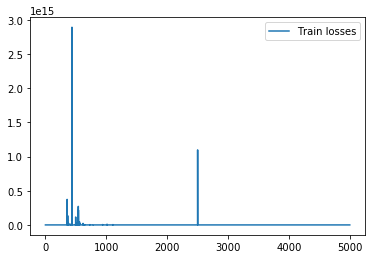

In [21]:
var_model = MLP_20(Vocab_size,20)
optimizer = torch.optim.SGD(var_model.parameters(),lr=0.09)
loss_func = nn.CrossEntropyLoss()
model_100, losses_100 = train_5000(var_model,train_loader,optimizer,loss_func)

Iteration: 1 Loss: 3.0458872318267822
Iteration: 2 Loss: 2.932128667831421
Iteration: 3 Loss: 3.02866268157959
Iteration: 4 Loss: 3.0096707344055176
Iteration: 5 Loss: 3.066458225250244
Iteration: 6 Loss: 3.3095030784606934
Iteration: 7 Loss: 3.2724480628967285
Iteration: 8 Loss: 3.4598944187164307
Iteration: 9 Loss: 3.6498565673828125
Iteration: 10 Loss: 3.845832109451294
Iteration: 11 Loss: 3.6032116413116455
Iteration: 12 Loss: 4.02323579788208
Iteration: 13 Loss: 4.216039657592773
Iteration: 14 Loss: 3.979823112487793
Iteration: 15 Loss: 4.25480318069458
Iteration: 16 Loss: 4.601496696472168
Iteration: 17 Loss: 4.354849338531494
Iteration: 18 Loss: 4.465338230133057
Iteration: 19 Loss: 4.588446140289307
Iteration: 20 Loss: 4.4042887687683105
Iteration: 21 Loss: 4.463882923126221
Iteration: 22 Loss: 4.2614922523498535
Iteration: 23 Loss: 4.549380779266357
Iteration: 24 Loss: 4.491610527038574
Iteration: 25 Loss: 4.217903137207031
Iteration: 26 Loss: 4.636702537536621
Iteration: 27 L

Iteration: 217 Loss: 4.262396812438965
Iteration: 218 Loss: 3.8888626098632812
Iteration: 219 Loss: 4.067679405212402
Iteration: 220 Loss: 4.0019121170043945
Iteration: 221 Loss: 4.036633491516113
Iteration: 222 Loss: 4.320666313171387
Iteration: 223 Loss: 3.3557605743408203
Iteration: 224 Loss: 4.193980693817139
Iteration: 225 Loss: 3.9686944484710693
Iteration: 226 Loss: 3.507002115249634
Iteration: 227 Loss: 3.7804083824157715
Iteration: 228 Loss: 3.7182724475860596
Iteration: 229 Loss: 4.035830020904541
Iteration: 230 Loss: 3.7760744094848633
Iteration: 231 Loss: 3.7196526527404785
Iteration: 232 Loss: 3.7237093448638916
Iteration: 233 Loss: 3.708911418914795
Iteration: 234 Loss: 4.446325302124023
Iteration: 235 Loss: 4.039924144744873
Iteration: 236 Loss: 4.039127349853516
Iteration: 237 Loss: 4.222390174865723
Iteration: 238 Loss: 4.057451248168945
Iteration: 239 Loss: 4.205583095550537
Iteration: 240 Loss: 4.583921432495117
Iteration: 241 Loss: 4.64369010925293
Iteration: 242 Lo

Iteration: 433 Loss: 3.607586622238159
Iteration: 434 Loss: 4.107467174530029
Iteration: 435 Loss: 3.9597654342651367
Iteration: 436 Loss: 3.8221404552459717
Iteration: 437 Loss: 3.648524761199951
Iteration: 438 Loss: 4.122744083404541
Iteration: 439 Loss: 3.9326937198638916
Iteration: 440 Loss: 3.951796531677246
Iteration: 441 Loss: 3.7778496742248535
Iteration: 442 Loss: 3.953727960586548
Iteration: 443 Loss: 4.200364112854004
Iteration: 444 Loss: 4.020742416381836
Iteration: 445 Loss: 4.2179718017578125
Iteration: 446 Loss: 3.618872880935669
Iteration: 447 Loss: 4.114227294921875
Iteration: 448 Loss: 3.3177192211151123
Iteration: 449 Loss: 4.096634387969971
Iteration: 450 Loss: 3.9801645278930664
Iteration: 451 Loss: 4.031244277954102
Iteration: 452 Loss: 4.108397006988525
Iteration: 453 Loss: 4.047633171081543
Iteration: 454 Loss: 3.5570287704467773
Iteration: 455 Loss: 4.012707710266113
Iteration: 456 Loss: 3.926348924636841
Iteration: 457 Loss: 4.299800395965576
Iteration: 458 Lo

Iteration: 647 Loss: 3.808429479598999
Iteration: 648 Loss: 3.6759870052337646
Iteration: 649 Loss: 3.931148052215576
Iteration: 650 Loss: 4.050146579742432
Iteration: 651 Loss: 4.195568084716797
Iteration: 652 Loss: 4.086268901824951
Iteration: 653 Loss: 3.78166127204895
Iteration: 654 Loss: 3.9121387004852295
Iteration: 655 Loss: 4.050045967102051
Iteration: 656 Loss: 3.9319446086883545
Iteration: 657 Loss: 3.968592643737793
Iteration: 658 Loss: 4.21558952331543
Iteration: 659 Loss: 3.9641191959381104
Iteration: 660 Loss: 4.033553600311279
Iteration: 661 Loss: 4.323540210723877
Iteration: 662 Loss: 4.049594402313232
Iteration: 663 Loss: 4.227271556854248
Iteration: 664 Loss: 4.367350101470947
Iteration: 665 Loss: 4.230647087097168
Iteration: 666 Loss: 4.523192882537842
Iteration: 667 Loss: 4.043119430541992
Iteration: 668 Loss: 4.042503833770752
Iteration: 669 Loss: 3.917433977127075
Iteration: 670 Loss: 3.8485608100891113
Iteration: 671 Loss: 3.6527602672576904
Iteration: 672 Loss: 

Iteration: 865 Loss: 4.565261363983154
Iteration: 866 Loss: 4.326138496398926
Iteration: 867 Loss: 4.450944900512695
Iteration: 868 Loss: 4.6496405601501465
Iteration: 869 Loss: 4.0103983879089355
Iteration: 870 Loss: 4.2708611488342285
Iteration: 871 Loss: 4.256423473358154
Iteration: 872 Loss: 4.392604827880859
Iteration: 873 Loss: 4.291027069091797
Iteration: 874 Loss: 4.7188520431518555
Iteration: 875 Loss: 4.075711727142334
Iteration: 876 Loss: 4.267815589904785
Iteration: 877 Loss: 4.3333940505981445
Iteration: 878 Loss: 4.177239418029785
Iteration: 879 Loss: 4.2286272048950195
Iteration: 880 Loss: 4.104067802429199
Iteration: 881 Loss: 4.059821605682373
Iteration: 882 Loss: 3.7908871173858643
Iteration: 883 Loss: 3.751267671585083
Iteration: 884 Loss: 3.7416367530822754
Iteration: 885 Loss: 3.4294023513793945
Iteration: 886 Loss: 4.106901168823242
Iteration: 887 Loss: 3.8745944499969482
Iteration: 888 Loss: 3.8818280696868896
Iteration: 889 Loss: 3.84763240814209
Iteration: 890 

Iteration: 1075 Loss: 4.240358352661133
Iteration: 1076 Loss: 3.8511781692504883
Iteration: 1077 Loss: 3.705796003341675
Iteration: 1078 Loss: 3.8327441215515137
Iteration: 1079 Loss: 3.6862194538116455
Iteration: 1080 Loss: 3.6761903762817383
Iteration: 1081 Loss: 3.4729418754577637
Iteration: 1082 Loss: 3.6773593425750732
Iteration: 1083 Loss: 3.6668519973754883
Iteration: 1084 Loss: 3.7577064037323
Iteration: 1085 Loss: 3.8963942527770996
Iteration: 1086 Loss: 3.8056299686431885
Iteration: 1087 Loss: 3.5961108207702637
Iteration: 1088 Loss: 3.808398962020874
Iteration: 1089 Loss: 3.932778835296631
Iteration: 1090 Loss: 3.933713912963867
Iteration: 1091 Loss: 4.065385341644287
Iteration: 1092 Loss: 3.9035537242889404
Iteration: 1093 Loss: 4.040090084075928
Iteration: 1094 Loss: 4.111875057220459
Iteration: 1095 Loss: 4.029638767242432
Iteration: 1096 Loss: 3.7934987545013428
Iteration: 1097 Loss: 3.924978256225586
Iteration: 1098 Loss: 3.927367925643921
Iteration: 1099 Loss: 4.339176

Iteration: 1280 Loss: 4.099375247955322
Iteration: 1281 Loss: 4.195243835449219
Iteration: 1282 Loss: 4.2064642906188965
Iteration: 1283 Loss: 4.008013725280762
Iteration: 1284 Loss: 4.150695323944092
Iteration: 1285 Loss: 4.045659065246582
Iteration: 1286 Loss: 4.947381973266602
Iteration: 1287 Loss: 4.2598490715026855
Iteration: 1288 Loss: 4.19767951965332
Iteration: 1289 Loss: 4.616066932678223
Iteration: 1290 Loss: 4.244459629058838
Iteration: 1291 Loss: 4.541943073272705
Iteration: 1292 Loss: 4.584813594818115
Iteration: 1293 Loss: 4.409212589263916
Iteration: 1294 Loss: 4.315556526184082
Iteration: 1295 Loss: 4.298349857330322
Iteration: 1296 Loss: 4.72094202041626
Iteration: 1297 Loss: 4.766488552093506
Iteration: 1298 Loss: 4.540501594543457
Iteration: 1299 Loss: 4.770869255065918
Iteration: 1300 Loss: 4.583961009979248
Iteration: 1301 Loss: 4.8761091232299805
Iteration: 1302 Loss: 4.481996536254883
Iteration: 1303 Loss: 4.487110137939453
Iteration: 1304 Loss: 4.387304306030273

Iteration: 1489 Loss: 4.336465358734131
Iteration: 1490 Loss: 4.484076023101807
Iteration: 1491 Loss: 3.97025728225708
Iteration: 1492 Loss: 4.130571365356445
Iteration: 1493 Loss: 4.621092319488525
Iteration: 1494 Loss: 4.1853928565979
Iteration: 1495 Loss: 4.208102703094482
Iteration: 1496 Loss: 4.271927833557129
Iteration: 1497 Loss: 4.053786754608154
Iteration: 1498 Loss: 4.251192569732666
Iteration: 1499 Loss: 3.9834184646606445
Iteration: 1500 Loss: 3.6656277179718018
Iteration: 1501 Loss: 3.8786988258361816
Iteration: 1502 Loss: 3.891489028930664
Iteration: 1503 Loss: 3.8623569011688232
Iteration: 1504 Loss: 4.094384670257568
Iteration: 1505 Loss: 3.6836984157562256
Iteration: 1506 Loss: 4.0351786613464355
Iteration: 1507 Loss: 4.04047966003418
Iteration: 1508 Loss: 3.6466493606567383
Iteration: 1509 Loss: 3.937258243560791
Iteration: 1510 Loss: 4.137493133544922
Iteration: 1511 Loss: 4.1849894523620605
Iteration: 1512 Loss: 4.1317644119262695
Iteration: 1513 Loss: 3.77422261238

Iteration: 1701 Loss: 4.213301658630371
Iteration: 1702 Loss: 4.2018513679504395
Iteration: 1703 Loss: 4.026747703552246
Iteration: 1704 Loss: 4.4053874015808105
Iteration: 1705 Loss: 4.212841987609863
Iteration: 1706 Loss: 3.826735019683838
Iteration: 1707 Loss: 3.9193525314331055
Iteration: 1708 Loss: 3.7420876026153564
Iteration: 1709 Loss: 4.031125068664551
Iteration: 1710 Loss: 3.8674161434173584
Iteration: 1711 Loss: 3.652717351913452
Iteration: 1712 Loss: 3.727160930633545
Iteration: 1713 Loss: 3.7983264923095703
Iteration: 1714 Loss: 3.6153061389923096
Iteration: 1715 Loss: 3.5327389240264893
Iteration: 1716 Loss: 4.057605743408203
Iteration: 1717 Loss: 3.8636257648468018
Iteration: 1718 Loss: 3.544811964035034
Iteration: 1719 Loss: 3.7294673919677734
Iteration: 1720 Loss: 3.8794524669647217
Iteration: 1721 Loss: 3.9037604331970215
Iteration: 1722 Loss: 3.987435817718506
Iteration: 1723 Loss: 3.9278857707977295
Iteration: 1724 Loss: 3.7629997730255127
Iteration: 1725 Loss: 3.84

Iteration: 1905 Loss: 4.343780040740967
Iteration: 1906 Loss: 4.5114665031433105
Iteration: 1907 Loss: 4.4533371925354
Iteration: 1908 Loss: 4.257138252258301
Iteration: 1909 Loss: 3.550137996673584
Iteration: 1910 Loss: 3.9182937145233154
Iteration: 1911 Loss: 4.605566501617432
Iteration: 1912 Loss: 3.7388646602630615
Iteration: 1913 Loss: 4.254924774169922
Iteration: 1914 Loss: 4.271681308746338
Iteration: 1915 Loss: 4.7218403816223145
Iteration: 1916 Loss: 3.7297308444976807
Iteration: 1917 Loss: 4.344182014465332
Iteration: 1918 Loss: 4.443203926086426
Iteration: 1919 Loss: 4.121749401092529
Iteration: 1920 Loss: 4.3426618576049805
Iteration: 1921 Loss: 4.456448554992676
Iteration: 1922 Loss: 4.22799825668335
Iteration: 1923 Loss: 3.809002637863159
Iteration: 1924 Loss: 4.292811393737793
Iteration: 1925 Loss: 4.0359344482421875
Iteration: 1926 Loss: 3.973179340362549
Iteration: 1927 Loss: 4.3170366287231445
Iteration: 1928 Loss: 4.851886749267578
Iteration: 1929 Loss: 4.18335962295

Iteration: 2114 Loss: 3.730576992034912
Iteration: 2115 Loss: 3.7412145137786865
Iteration: 2116 Loss: 3.560995101928711
Iteration: 2117 Loss: 3.565140724182129
Iteration: 2118 Loss: 4.000215530395508
Iteration: 2119 Loss: 3.700603723526001
Iteration: 2120 Loss: 3.8076205253601074
Iteration: 2121 Loss: 3.919260263442993
Iteration: 2122 Loss: 3.816166400909424
Iteration: 2123 Loss: 3.811741352081299
Iteration: 2124 Loss: 4.014745712280273
Iteration: 2125 Loss: 3.942962646484375
Iteration: 2126 Loss: 3.85654878616333
Iteration: 2127 Loss: 4.016229152679443
Iteration: 2128 Loss: 3.709758996963501
Iteration: 2129 Loss: 4.282965660095215
Iteration: 2130 Loss: 4.192212104797363
Iteration: 2131 Loss: 4.316152572631836
Iteration: 2132 Loss: 4.449247360229492
Iteration: 2133 Loss: 3.8906874656677246
Iteration: 2134 Loss: 3.8176920413970947
Iteration: 2135 Loss: 4.114315986633301
Iteration: 2136 Loss: 3.8291242122650146
Iteration: 2137 Loss: 4.45123291015625
Iteration: 2138 Loss: 4.3664188385009

Iteration: 2324 Loss: 4.6009979248046875
Iteration: 2325 Loss: 4.738438606262207
Iteration: 2326 Loss: 4.793794631958008
Iteration: 2327 Loss: 4.680253982543945
Iteration: 2328 Loss: 4.762897968292236
Iteration: 2329 Loss: 4.528255939483643
Iteration: 2330 Loss: 4.905017852783203
Iteration: 2331 Loss: 4.575695037841797
Iteration: 2332 Loss: 4.406484603881836
Iteration: 2333 Loss: 4.733302593231201
Iteration: 2334 Loss: 4.951972961425781
Iteration: 2335 Loss: 4.3365068435668945
Iteration: 2336 Loss: 4.316806793212891
Iteration: 2337 Loss: 4.999388217926025
Iteration: 2338 Loss: 4.646330833435059
Iteration: 2339 Loss: 3.828340768814087
Iteration: 2340 Loss: 4.252627372741699
Iteration: 2341 Loss: 4.150391578674316
Iteration: 2342 Loss: 4.252664089202881
Iteration: 2343 Loss: 4.257505416870117
Iteration: 2344 Loss: 3.647728681564331
Iteration: 2345 Loss: 4.279029369354248
Iteration: 2346 Loss: 3.734471321105957
Iteration: 2347 Loss: 3.884133815765381
Iteration: 2348 Loss: 3.70335721969604

Iteration: 2532 Loss: 4.110507011413574
Iteration: 2533 Loss: 4.1798272132873535
Iteration: 2534 Loss: 4.038372039794922
Iteration: 2535 Loss: 4.041306018829346
Iteration: 2536 Loss: 4.079391002655029
Iteration: 2537 Loss: 3.9500932693481445
Iteration: 2538 Loss: 4.4088239669799805
Iteration: 2539 Loss: 3.952822208404541
Iteration: 2540 Loss: 4.2261576652526855
Iteration: 2541 Loss: 4.320735931396484
Iteration: 2542 Loss: 4.008567810058594
Iteration: 2543 Loss: 4.171241760253906
Iteration: 2544 Loss: 4.302428245544434
Iteration: 2545 Loss: 4.210312366485596
Iteration: 2546 Loss: 4.3252105712890625
Iteration: 2547 Loss: 4.206976413726807
Iteration: 2548 Loss: 3.58455753326416
Iteration: 2549 Loss: 4.106531143188477
Iteration: 2550 Loss: 4.158010959625244
Iteration: 2551 Loss: 3.9388906955718994
Iteration: 2552 Loss: 4.068213939666748
Iteration: 2553 Loss: 4.341545581817627
Iteration: 2554 Loss: 4.187163829803467
Iteration: 2555 Loss: 4.149167060852051
Iteration: 2556 Loss: 4.45822334289

Iteration: 2744 Loss: 3.7362682819366455
Iteration: 2745 Loss: 3.4955894947052
Iteration: 2746 Loss: 3.595132350921631
Iteration: 2747 Loss: 3.796152353286743
Iteration: 2748 Loss: 3.8272337913513184
Iteration: 2749 Loss: 3.9683780670166016
Iteration: 2750 Loss: 4.337168216705322
Iteration: 2751 Loss: 3.7396903038024902
Iteration: 2752 Loss: 4.230180263519287
Iteration: 2753 Loss: 4.121747970581055
Iteration: 2754 Loss: 3.849921941757202
Iteration: 2755 Loss: 4.363811016082764
Iteration: 2756 Loss: 4.367895126342773
Iteration: 2757 Loss: 4.651403903961182
Iteration: 2758 Loss: 4.508512496948242
Iteration: 2759 Loss: 4.756686210632324
Iteration: 2760 Loss: 4.288643836975098
Iteration: 2761 Loss: 4.689992904663086
Iteration: 2762 Loss: 4.4150471687316895
Iteration: 2763 Loss: 4.0183515548706055
Iteration: 2764 Loss: 4.757310390472412
Iteration: 2765 Loss: 3.880297899246216
Iteration: 2766 Loss: 4.449972152709961
Iteration: 2767 Loss: 4.546934604644775
Iteration: 2768 Loss: 4.178209304809

Iteration: 2954 Loss: 4.418785095214844
Iteration: 2955 Loss: 4.354238986968994
Iteration: 2956 Loss: 3.9533579349517822
Iteration: 2957 Loss: 4.034426212310791
Iteration: 2958 Loss: 4.4570159912109375
Iteration: 2959 Loss: 4.163621425628662
Iteration: 2960 Loss: 4.625797748565674
Iteration: 2961 Loss: 4.652777194976807
Iteration: 2962 Loss: 4.039914608001709
Iteration: 2963 Loss: 4.156874656677246
Iteration: 2964 Loss: 3.943377733230591
Iteration: 2965 Loss: 4.206579685211182
Iteration: 2966 Loss: 3.9790453910827637
Iteration: 2967 Loss: 3.99204158782959
Iteration: 2968 Loss: 3.999528169631958
Iteration: 2969 Loss: 4.046456813812256
Iteration: 2970 Loss: 4.382699489593506
Iteration: 2971 Loss: 4.383089542388916
Iteration: 2972 Loss: 4.706175327301025
Iteration: 2973 Loss: 4.292424201965332
Iteration: 2974 Loss: 4.274801254272461
Iteration: 2975 Loss: 4.805868148803711
Iteration: 2976 Loss: 3.795665979385376
Iteration: 2977 Loss: 4.361982345581055
Iteration: 2978 Loss: 4.29222726821899

Iteration: 3164 Loss: 3.758202075958252
Iteration: 3165 Loss: 3.7325751781463623
Iteration: 3166 Loss: 4.134654521942139
Iteration: 3167 Loss: 3.7215476036071777
Iteration: 3168 Loss: 3.9807868003845215
Iteration: 3169 Loss: 3.860530138015747
Iteration: 3170 Loss: 4.278632164001465
Iteration: 3171 Loss: 4.110918045043945
Iteration: 3172 Loss: 4.146754264831543
Iteration: 3173 Loss: 4.471345901489258
Iteration: 3174 Loss: 4.238426208496094
Iteration: 3175 Loss: 3.968198299407959
Iteration: 3176 Loss: 4.477973461151123
Iteration: 3177 Loss: 4.507405757904053
Iteration: 3178 Loss: 4.371858596801758
Iteration: 3179 Loss: 4.510959625244141
Iteration: 3180 Loss: 4.68540620803833
Iteration: 3181 Loss: 4.612926006317139
Iteration: 3182 Loss: 4.527490139007568
Iteration: 3183 Loss: 4.660607814788818
Iteration: 3184 Loss: 4.826290130615234
Iteration: 3185 Loss: 4.451678276062012
Iteration: 3186 Loss: 4.489284038543701
Iteration: 3187 Loss: 4.703747272491455
Iteration: 3188 Loss: 4.43132209777832

Iteration: 3377 Loss: 4.501335144042969
Iteration: 3378 Loss: 4.614963531494141
Iteration: 3379 Loss: 4.4417314529418945
Iteration: 3380 Loss: 4.69535493850708
Iteration: 3381 Loss: 4.868317604064941
Iteration: 3382 Loss: 4.535375118255615
Iteration: 3383 Loss: 4.621189594268799
Iteration: 3384 Loss: 4.806807994842529
Iteration: 3385 Loss: 5.145934581756592
Iteration: 3386 Loss: 4.522792339324951
Iteration: 3387 Loss: 4.655722618103027
Iteration: 3388 Loss: 4.879870414733887
Iteration: 3389 Loss: 4.630362033843994
Iteration: 3390 Loss: 4.328195095062256
Iteration: 3391 Loss: 4.797153949737549
Iteration: 3392 Loss: 3.960768699645996
Iteration: 3393 Loss: 4.783509731292725
Iteration: 3394 Loss: 4.413708686828613
Iteration: 3395 Loss: 3.917764902114868
Iteration: 3396 Loss: 4.833502292633057
Iteration: 3397 Loss: 4.940710544586182
Iteration: 3398 Loss: 4.659135818481445
Iteration: 3399 Loss: 4.5584492683410645
Iteration: 3400 Loss: 4.32326602935791
Iteration: 3401 Loss: 4.322417736053467


Iteration: 3588 Loss: 4.6980814933776855
Iteration: 3589 Loss: 5.303018569946289
Iteration: 3590 Loss: 4.52593469619751
Iteration: 3591 Loss: 5.115977764129639
Iteration: 3592 Loss: 5.038427829742432
Iteration: 3593 Loss: 4.662193298339844
Iteration: 3594 Loss: 4.863321781158447
Iteration: 3595 Loss: 4.598540782928467
Iteration: 3596 Loss: 4.437545299530029
Iteration: 3597 Loss: 5.0696702003479
Iteration: 3598 Loss: 4.371661186218262
Iteration: 3599 Loss: 4.690719127655029
Iteration: 3600 Loss: 4.853546619415283
Iteration: 3601 Loss: 4.266324520111084
Iteration: 3602 Loss: 4.632772445678711
Iteration: 3603 Loss: 4.69973087310791
Iteration: 3604 Loss: 4.040067195892334
Iteration: 3605 Loss: 4.466466903686523
Iteration: 3606 Loss: 4.165663719177246
Iteration: 3607 Loss: 3.9535040855407715
Iteration: 3608 Loss: 4.058239459991455
Iteration: 3609 Loss: 4.103329181671143
Iteration: 3610 Loss: 4.187742710113525
Iteration: 3611 Loss: 3.7787270545959473
Iteration: 3612 Loss: 4.292744159698486
I

Iteration: 3797 Loss: 5.549206733703613
Iteration: 3798 Loss: 5.38447380065918
Iteration: 3799 Loss: 4.602447032928467
Iteration: 3800 Loss: 4.938454627990723
Iteration: 3801 Loss: 5.5003252029418945
Iteration: 3802 Loss: 4.679738998413086
Iteration: 3803 Loss: 4.651394844055176
Iteration: 3804 Loss: 4.712457656860352
Iteration: 3805 Loss: 5.162832260131836
Iteration: 3806 Loss: 5.457616806030273
Iteration: 3807 Loss: 4.123172283172607
Iteration: 3808 Loss: 4.828029155731201
Iteration: 3809 Loss: 4.836767196655273
Iteration: 3810 Loss: 4.296966075897217
Iteration: 3811 Loss: 5.116458892822266
Iteration: 3812 Loss: 4.647854328155518
Iteration: 3813 Loss: 4.738291263580322
Iteration: 3814 Loss: 4.249731540679932
Iteration: 3815 Loss: 4.821533679962158
Iteration: 3816 Loss: 5.209792613983154
Iteration: 3817 Loss: 4.885343551635742
Iteration: 3818 Loss: 4.733074188232422
Iteration: 3819 Loss: 4.713960647583008
Iteration: 3820 Loss: 4.660399436950684
Iteration: 3821 Loss: 4.4408369064331055

Iteration: 4009 Loss: 4.520474910736084
Iteration: 4010 Loss: 4.8223371505737305
Iteration: 4011 Loss: 4.913637638092041
Iteration: 4012 Loss: 4.285676956176758
Iteration: 4013 Loss: 4.254508018493652
Iteration: 4014 Loss: 4.228281021118164
Iteration: 4015 Loss: 4.492568016052246
Iteration: 4016 Loss: 4.618043899536133
Iteration: 4017 Loss: 5.093736171722412
Iteration: 4018 Loss: 4.747119426727295
Iteration: 4019 Loss: 5.017962455749512
Iteration: 4020 Loss: 4.416387557983398
Iteration: 4021 Loss: 4.8742499351501465
Iteration: 4022 Loss: 5.337114334106445
Iteration: 4023 Loss: 4.552980422973633
Iteration: 4024 Loss: 4.840529918670654
Iteration: 4025 Loss: 4.78655481338501
Iteration: 4026 Loss: 4.530257701873779
Iteration: 4027 Loss: 4.593486309051514
Iteration: 4028 Loss: 4.659683704376221
Iteration: 4029 Loss: 4.488336563110352
Iteration: 4030 Loss: 4.583331108093262
Iteration: 4031 Loss: 4.503078460693359
Iteration: 4032 Loss: 4.811315059661865
Iteration: 4033 Loss: 4.418238162994385

Iteration: 4219 Loss: 4.619155406951904
Iteration: 4220 Loss: 4.599313259124756
Iteration: 4221 Loss: 5.012238502502441
Iteration: 4222 Loss: 5.3575849533081055
Iteration: 4223 Loss: 4.606456756591797
Iteration: 4224 Loss: 4.7441911697387695
Iteration: 4225 Loss: 4.981034755706787
Iteration: 4226 Loss: 5.22390604019165
Iteration: 4227 Loss: 4.898216724395752
Iteration: 4228 Loss: 4.446933746337891
Iteration: 4229 Loss: 4.311135292053223
Iteration: 4230 Loss: 4.897520065307617
Iteration: 4231 Loss: 4.688043594360352
Iteration: 4232 Loss: 4.700748443603516
Iteration: 4233 Loss: 4.485590934753418
Iteration: 4234 Loss: 4.493060111999512
Iteration: 4235 Loss: 5.324283599853516
Iteration: 4236 Loss: 4.508251190185547
Iteration: 4237 Loss: 4.369324207305908
Iteration: 4238 Loss: 5.210122585296631
Iteration: 4239 Loss: 5.002771854400635
Iteration: 4240 Loss: 4.898937225341797
Iteration: 4241 Loss: 4.766921520233154
Iteration: 4242 Loss: 4.687829971313477
Iteration: 4243 Loss: 4.610106945037842

Iteration: 4433 Loss: 3.9478836059570312
Iteration: 4434 Loss: 3.795743942260742
Iteration: 4435 Loss: 4.074513912200928
Iteration: 4436 Loss: 4.1524739265441895
Iteration: 4437 Loss: 4.209731578826904
Iteration: 4438 Loss: 4.109968185424805
Iteration: 4439 Loss: 4.191789627075195
Iteration: 4440 Loss: 4.273440837860107
Iteration: 4441 Loss: 4.524501800537109
Iteration: 4442 Loss: 4.2056474685668945
Iteration: 4443 Loss: 4.446494102478027
Iteration: 4444 Loss: 4.523748397827148
Iteration: 4445 Loss: 4.262007236480713
Iteration: 4446 Loss: 4.001142501831055
Iteration: 4447 Loss: 4.589206695556641
Iteration: 4448 Loss: 4.0937323570251465
Iteration: 4449 Loss: 4.180351734161377
Iteration: 4450 Loss: 4.091897487640381
Iteration: 4451 Loss: 4.246088027954102
Iteration: 4452 Loss: 4.246531009674072
Iteration: 4453 Loss: 4.204905986785889
Iteration: 4454 Loss: 4.046743392944336
Iteration: 4455 Loss: 4.385047435760498
Iteration: 4456 Loss: 4.604590892791748
Iteration: 4457 Loss: 4.919034004211

Iteration: 4639 Loss: 4.609234809875488
Iteration: 4640 Loss: 4.999349594116211
Iteration: 4641 Loss: 4.777508735656738
Iteration: 4642 Loss: 6.087297439575195
Iteration: 4643 Loss: 4.554376125335693
Iteration: 4644 Loss: 4.730164527893066
Iteration: 4645 Loss: 4.645001411437988
Iteration: 4646 Loss: 5.01938009262085
Iteration: 4647 Loss: 5.606270790100098
Iteration: 4648 Loss: 5.188859939575195
Iteration: 4649 Loss: 5.077386379241943
Iteration: 4650 Loss: 5.528706073760986
Iteration: 4651 Loss: 4.7566447257995605
Iteration: 4652 Loss: 5.094354629516602
Iteration: 4653 Loss: 4.821749210357666
Iteration: 4654 Loss: 5.442827224731445
Iteration: 4655 Loss: 5.104371547698975
Iteration: 4656 Loss: 5.014461994171143
Iteration: 4657 Loss: 4.132543563842773
Iteration: 4658 Loss: 4.721080780029297
Iteration: 4659 Loss: 4.91166353225708
Iteration: 4660 Loss: 4.283890247344971
Iteration: 4661 Loss: 5.330522060394287
Iteration: 4662 Loss: 4.664865016937256
Iteration: 4663 Loss: 4.933337211608887
I

Iteration: 4853 Loss: 4.592688083648682
Iteration: 4854 Loss: 4.430601119995117
Iteration: 4855 Loss: 4.6142754554748535
Iteration: 4856 Loss: 4.445314407348633
Iteration: 4857 Loss: 4.470186710357666
Iteration: 4858 Loss: 4.188212871551514
Iteration: 4859 Loss: 4.5226030349731445
Iteration: 4860 Loss: 4.586915969848633
Iteration: 4861 Loss: 4.425650119781494
Iteration: 4862 Loss: 4.139796733856201
Iteration: 4863 Loss: 4.483536720275879
Iteration: 4864 Loss: 4.481858253479004
Iteration: 4865 Loss: 4.446362495422363
Iteration: 4866 Loss: 4.005182266235352
Iteration: 4867 Loss: 4.192856788635254
Iteration: 4868 Loss: 4.51349401473999
Iteration: 4869 Loss: 4.391458988189697
Iteration: 4870 Loss: 4.719656467437744
Iteration: 4871 Loss: 4.222335338592529
Iteration: 4872 Loss: 4.25009298324585
Iteration: 4873 Loss: 4.24831485748291
Iteration: 4874 Loss: 4.5297160148620605
Iteration: 4875 Loss: 3.991778612136841
Iteration: 4876 Loss: 4.147829532623291
Iteration: 4877 Loss: 4.235431671142578


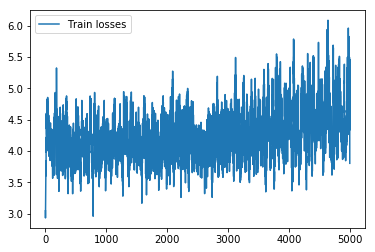

In [16]:
optimizer = torch.optim.SGD(var_model.parameters(),lr=0.1)
loss_func = nn.CrossEntropyLoss()
model_100, losses_100 = train_5000(var_model,train_loader,optimizer,loss_func)